In [2]:
from warnings import simplefilter
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import astropy.units as u
from astropy import constants as const
from matplotlib.gridspec import GridSpec
from scipy import integrate

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.ParserWarning)

In [3]:
all_models_with_qs = pd.read_csv('all_models_with_qs.csv', index_col=0)


/var/folders/cb/t7f9wn6d0_v4b9j9886w59pdjg8xs7/T/ipykernel_49566/4067797129.py:1: DtypeWarning: Columns (211,212,213,214) have mixed types. Specify dtype option on import or set low_memory=False.
  all_models_with_qs = pd.read_csv('all_models_with_qs.csv', index_col=0)


In [4]:
def make_all_qs(all_models_with_qs):
    all_qs = (
        all_models_with_qs.reset_index()[['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh']]
        .drop_duplicates(subset=['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh'], keep='last')
    .assign(
        Q_intermediate_Q_low = lambda x: x.Q_intermediate/x.Q_low,
        Q_high_Q_low = lambda x: x.Q_high/x.Q_low,
        Q_high_Q_intermediate = lambda x: x.Q_high/x.Q_intermediate,
        Q_very_high_Q_low = lambda x: x.Q_very_high/x.Q_low,
        Q_very_high_Q_intermediate = lambda x: x.Q_very_high/x.Q_intermediate,
        Q_very_high_Q_high = lambda x: x.Q_very_high/x.Q_high,
    ))
    return all_qs

def log_likelihood(data, model, uncertainty):
    return -0.5 * (data - model) ** 2 / uncertainty**2


def log_prior_logU(logU):
    return np.where((logU >= -4)&(logU <= -1), 0, -np.inf)


def bpt_kewley_2001(logniiha):
	'''
	Defining the BPT AGN/SF dividing line from Kewley 2001.
	'''    
	return 0.61/(logniiha - 0.47) + 1.19   


# def plot_bpt_kewley_2001(ax, label=True):
#     x = np.linspace(-2,0.46, 1000)
#     ax.plot(x, bpt_kewley_2001(x), c='black', ls='-', lw=3, label='Kewley et al. 2001' if label else None, zorder=-9)
    
def plot_bpt_kewley_2001(ax, label=True):
    x = np.linspace(-2,0.46, 1000)
    ax.plot(10**x, 10**bpt_kewley_2001(x), c='black', ls='-', lw=3, label='Kewley et al. 2001' if label else None, zorder=-9)
    

def bpt_kauffmann_2003(logniiha):
	'''
	Defining the BPT AGN/SF dividing line from Kauffmann 2003.
	'''    
	return 0.61/(logniiha - 0.05) + 1.3    

    
# def plot_bpt_kauffmann_2003(ax, label=True):
#     x = np.linspace(-2,0.04, 1000)
#     ax.plot(x, bpt_kauffmann_2003(x), c='black', ls='--', lw=3, label='Kauffmann et al. 2003' if label else None, zorder=-9)
    

def plot_bpt_kauffmann_2003(ax, label=True):
    x = np.linspace(-2,0.04, 1000)
    ax.plot(10**x, 10**bpt_kauffmann_2003(x), c='black', ls='--', lw=3, label='Kauffmann et al. 2003' if label else None, zorder=-9)

    
def calculate_quantile(parameter_array, probability_array, quantile):
    p = parameter_array[np.where(np.cumsum(probability_array) > quantile)[0][0]]
    return p

def calculate_quantiles_16_50_84(parameter_array, probability_array):
    q_16 = calculate_quantile(parameter_array, probability_array, 0.16)
    q_50 = calculate_quantile(parameter_array, probability_array, 0.50)
    q_84 = calculate_quantile(parameter_array, probability_array, 0.84)
    return q_16, q_50, q_84

def calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty):
    NII_Ha_data = np.array([NII_Ha_data])
    OIII_Hb_data = np.array([OIII_Hb_data])
    NII_Ha_uncertainty = np.array([NII_Ha_uncertainty])
    OIII_Hb_uncertainty = np.array([OIII_Hb_uncertainty])
    bpt_inference = pd.DataFrame(index=pd.MultiIndex.from_product([OIII_Hb_data, NII_Ha_data, all_models_with_qs.index], names=['data_OIII_Hb', 'data_NII_Ha', 'sed'])).assign(
        model_OIII = lambda x: [all_models_with_qs.at[sed, 'O_3_5006.84A'] for sed in x.index.get_level_values('sed')],
        model_Hb = lambda x: [all_models_with_qs.at[sed, 'H_1_4861.33A'] for sed in x.index.get_level_values('sed')],
        model_NII = lambda x: [all_models_with_qs.at[sed, 'N_2_6583.45A'] for sed in x.index.get_level_values('sed')],
        model_Ha = lambda x: [all_models_with_qs.at[sed, 'H_1_6562.81A'] for sed in x.index.get_level_values('sed')], 
        logU = lambda x: [all_models_with_qs.at[sed, 'logU'] for sed in x.index.get_level_values('sed')],
        zgas = lambda x: [all_models_with_qs.at[sed, 'zgas'] for sed in x.index.get_level_values('sed')],
        hden = lambda x: [all_models_with_qs.at[sed, 'hden'] for sed in x.index.get_level_values('sed')],
        Q_total = lambda x: [all_models_with_qs.at[sed, 'Q_total'] for sed in x.index.get_level_values('sed')],
        Q_low = lambda x: [all_models_with_qs.at[sed, 'Q_low'] for sed in x.index.get_level_values('sed')],
        Q_intermediate = lambda x: [all_models_with_qs.at[sed, 'Q_intermediate'] for sed in x.index.get_level_values('sed')],
        Q_high = lambda x: [all_models_with_qs.at[sed, 'Q_high'] for sed in x.index.get_level_values('sed')],
        Q_very_high = lambda x: [all_models_with_qs.at[sed, 'Q_very_high'] for sed in x.index.get_level_values('sed')]
        ).reset_index().assign(
        model_OIII_Hb = lambda x: x.model_OIII/x.model_Hb,
        log_model_OIII_Hb = lambda x: np.log10(x.model_OIII_Hb),
        model_NII_Ha = lambda x: x.model_NII/x.model_Ha,
        log_model_NII_Ha = lambda x: np.log10(x.model_NII_Ha),
        log_likelihood_OIII_Hb = lambda x: log_likelihood(data=x.data_OIII_Hb, model=x.model_OIII_Hb, uncertainty=OIII_Hb_uncertainty),
        log_likelihood_NII_Ha = lambda x: log_likelihood(data=x.data_NII_Ha, model=x.model_NII_Ha, uncertainty=NII_Ha_uncertainty), 
        likelihood_BPT = lambda x: np.exp(x.log_likelihood_OIII_Hb+x.log_likelihood_NII_Ha),
        likelihood_BPT_norm = lambda x: x.likelihood_BPT/x.groupby(['data_NII_Ha', 'data_OIII_Hb'])['likelihood_BPT'].transform('sum'),
        likelihood_weighted_logU = lambda x: x.logU*x.likelihood_BPT_norm,
        likelihood_weighted_zgas = lambda x: x.zgas*x.likelihood_BPT_norm,
        likelihood_weighted_Q_total = lambda x: x.Q_total*x.likelihood_BPT_norm,
        likelihood_weighted_Q_low = lambda x: x.Q_low*x.likelihood_BPT_norm,
        likelihood_weighted_Q_intermediate = lambda x: x.Q_intermediate*x.likelihood_BPT_norm,
        likelihood_weighted_Q_high = lambda x: x.Q_high*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high = lambda x: x.Q_very_high*x.likelihood_BPT_norm,
        likelihood_weighted_Q_intermediate_Q_low = lambda x: (x.Q_intermediate/x.Q_low)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_high_Q_intermediate = lambda x:(x.Q_high/x.Q_intermediate)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_high_Q_low = lambda x: (x.Q_high/x.Q_low)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high_Q_low = lambda x: (x.Q_very_high/x.Q_low)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high_Q_intermediate = lambda x: (x.Q_very_high/x.Q_intermediate)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high_Q_high = lambda x: (x.Q_very_high/x.Q_high)*x.likelihood_BPT_norm,
    )
    return bpt_inference


def plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax):
    plot_bpt_kewley_2001(ax, label=True)
    plot_bpt_kauffmann_2003(ax, label=True)
    ax.errorbar(NII_Ha_data, OIII_Hb_data, xerr=NII_Ha_uncertainty, yerr=OIII_Hb_uncertainty, c='red', label='Data', marker='o')
    ax.set_xlim(10**-2.25, 10**0.75)
    ax.set_ylim(10**-1.75, 10**1.75)
    ax.set_xlabel(r'$\log\frac{\rm{[N~II]}}{\rm{H}\alpha}$')
    ax.set_ylabel(r'$\log\frac{\rm{[O~III]}~\lambda5008}{\rm{H}\beta}$')
    ax.annotate('BPT', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')
    ax.legend(fontsize=10)
    ax.set_xscale('log')
    ax.set_yscale('log')


def plot_posterior_logU(bpt_inference_df, ax):
    bpt_groupby_logU = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'logU'], observed=True).sum().reset_index()
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm']) 
    ax.step(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm'], where='mid', lw=6, c='blue')
    ax.axvspan(q_16, q_84, color='blue', alpha=0.25)
    ax.axvline(q_50, c='blue', ls=':')
    ax.set_xlabel('log U')
    ax.set_ylabel('P(log U | data)')


def plot_posterior_Zgas(bpt_inference_df, ax):
    bpt_groupby_zgas = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'zgas'], observed=True).sum().reset_index()
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(bpt_groupby_zgas['zgas'], bpt_groupby_zgas['likelihood_BPT_norm'])
    ax.step(bpt_groupby_zgas['zgas'], bpt_groupby_zgas['likelihood_BPT_norm'], where='mid', lw=6, c='red')
    ax.axvspan(q_16, q_84, color='red', alpha=0.25)
    ax.axvline(q_50, c='red', ls=':')
    ax.set_xlabel(r'Z$_{\rm{gas}}$/Z$_\odot$')
    ax.set_ylabel(r'P(Z$_{\rm{gas}}$/Z$_\odot$ | data)')


def make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_intermediate_Q_low'] = pd.cut(np.log10(bpt_inference_dummy['Q_intermediate']/bpt_inference_dummy['Q_low']), bins=50)
    bpt_inference_dummy['bins_centers_Q_intermediate_Q_low'] = bpt_inference_dummy['bins_Q_intermediate_Q_low'].apply(lambda x: x.mid)
    bpt_groupby_Q_intermediate_Q_low = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_intermediate_Q_low', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_intermediate_Q_low'], observed=True).sum().reset_index()
    return bpt_groupby_Q_intermediate_Q_low


def plot_posterior_Q_intermediate_Q_low(bpt_inference_df, ax):
    bpt_groupby_Q_intermediate_Q_low = make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$ | data)')


def make_bpt_groupby_Q_high_Q_low(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_high_Q_low'] = pd.cut(np.log10(bpt_inference_dummy['Q_high']/bpt_inference_dummy['Q_low']), bins=50)
    bpt_inference_dummy['bins_centers_Q_high_Q_low'] = bpt_inference_dummy['bins_Q_high_Q_low'].apply(lambda x: x.mid)
    bpt_groupby_Q_high_Q_low = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_high_Q_low', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_high_Q_low'], observed=True).sum().reset_index()
    return bpt_groupby_Q_high_Q_low


def plot_posterior_Q_high_Q_low(bpt_inference_df, ax):
    bpt_groupby_Q_high_Q_low = make_bpt_groupby_Q_high_Q_low(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{high}}$/Q$_{\rm{low}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{high}}$/Q$_{\rm{low}}$ | data)')


def make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_high_Q_intermediate'] = pd.cut(np.log10(bpt_inference_dummy['Q_high']/bpt_inference_dummy['Q_intermediate']), bins=50)
    bpt_inference_dummy['bins_centers_Q_high_Q_intermediate'] = bpt_inference_dummy['bins_Q_high_Q_intermediate'].apply(lambda x: x.mid)
    bpt_groupby_Q_high_Q_intermediate = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_high_Q_intermediate', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_high_Q_intermediate'], observed=True).sum().reset_index()
    return bpt_groupby_Q_high_Q_intermediate


def plot_posterior_Q_high_Q_intermediate(bpt_inference_df, ax):
    bpt_groupby_Q_high_Q_intermediate = make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{high}}$/Q$_{\rm{intermediate}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{high}}$/Q$_{\rm{intermediate}}$ | data)')


def make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_low'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_low']), bins=50)
    bpt_inference_dummy['bins_centers_Q_very_high_Q_low'] = bpt_inference_dummy['bins_Q_very_high_Q_low'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_low = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_low', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_low'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_low


def plot_posterior_Q_very_high_Q_low(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_low = make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{very~high}}$/Q$_{\rm{low}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{very~high}}$/Q$_{\rm{low}}$ | data)')


def make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_intermediate'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_intermediate']), bins=50)
    bpt_inference_dummy['bins_centers_Q_very_high_Q_intermediate'] = bpt_inference_dummy['bins_Q_very_high_Q_intermediate'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_intermediate = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_intermediate', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_intermediate'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_intermediate


def plot_posterior_Q_very_high_Q_intermediate(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_intermediate = make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{very~high}}$/Q$_{\rm{intermediate}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{very~high}}$/Q$_{\rm{intermediate}}$ | data)')
    

def make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_high'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_high']), bins=50)
    bpt_inference_dummy['bins_centers_Q_very_high_Q_high'] = bpt_inference_dummy['bins_Q_very_high_Q_high'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_high = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_high', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_high'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_high


def plot_posterior_Q_very_high_Q_high(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_high = make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{very~high}}$/Q$_{\rm{high}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{very~high}}$/Q$_{\rm{high}}$ | data)')

def make_quantiles_df(bpt_inference_df):
    bpt_groupby_logU = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'logU'], observed=True).sum().reset_index()
    bpt_groupby_zgas = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'zgas'], observed=True).sum().reset_index()
    bpt_groupby_Q_intermediate_Q_low = make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df)
    bpt_groupby_Q_high_Q_low = make_bpt_groupby_Q_high_Q_low(bpt_inference_df)
    bpt_groupby_Q_high_Q_intermediate = make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df)
    bpt_groupby_Q_very_high_Q_low = make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df)
    bpt_groupby_Q_very_high_Q_intermediate = make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df)
    bpt_groupby_Q_very_high_Q_high = make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df)

    data = {
        'logU':calculate_quantiles_16_50_84(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm']), 
        'zgas':calculate_quantiles_16_50_84(bpt_groupby_zgas['zgas'], bpt_groupby_zgas['likelihood_BPT_norm']), 
        'Q_intermediate_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm']),
        'Q_high_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm']),
        'Q_high_Q_intermediate':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm']),
        'Q_very_high_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm']),
        'Q_very_high_Q_intermediate':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm']),
        'Q_very_high_Q_high':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'])
    }

    quantiles_df = pd.DataFrame(data=data, index=['q_16', 'q_50', 'q_84']).T
    return quantiles_df

def find_model_matches(bpt_inference_df, models_df):
    quantiles_df = make_quantiles_df(bpt_inference_df)
    q_conditions = (models_df['Q_intermediate']/models_df['Q_low'] > 10**quantiles_df.loc['Q_intermediate_Q_low', 'q_16'])&\
                   (models_df['Q_intermediate']/models_df['Q_low'] < 10**quantiles_df.loc['Q_intermediate_Q_low', 'q_84'])&\
                   (models_df['Q_high']/models_df['Q_low'] > 10**quantiles_df.loc['Q_high_Q_low', 'q_16'])&\
                   (models_df['Q_high']/models_df['Q_low'] < 10**quantiles_df.loc['Q_high_Q_low', 'q_84'])&\
                   (models_df['Q_high']/models_df['Q_intermediate'] > 10**quantiles_df.loc['Q_high_Q_intermediate', 'q_16'])&\
                   (models_df['Q_high']/models_df['Q_intermediate'] < 10**quantiles_df.loc['Q_high_Q_intermediate', 'q_84'])&\
                   (models_df['Q_very_high']/models_df['Q_low'] > 10**quantiles_df.loc['Q_very_high_Q_low', 'q_16'])&\
                   (models_df['Q_very_high']/models_df['Q_low'] < 10**quantiles_df.loc['Q_very_high_Q_low', 'q_84'])&\
                   (models_df['Q_very_high']/models_df['Q_intermediate'] > 10**quantiles_df.loc['Q_very_high_Q_intermediate', 'q_16'])&\
                   (models_df['Q_very_high']/models_df['Q_intermediate'] < 10**quantiles_df.loc['Q_very_high_Q_intermediate', 'q_84'])&\
                   (models_df['Q_very_high']/models_df['Q_high'] > 10**quantiles_df.loc['Q_very_high_Q_high', 'q_16'])&\
                   (models_df['Q_very_high']/models_df['Q_high'] < 10**quantiles_df.loc['Q_very_high_Q_high', 'q_84'])
                    
    model_matches_df = models_df[q_conditions]
    return model_matches_df


def main_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty):
    bpt_inference_df = calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty)

    fig = plt.figure(figsize=(20,20))
    gs = GridSpec(nrows=3, ncols=3)
    gs.update(wspace=0.35, hspace=0.35)
    ax = fig.add_subplot(gs[0:1, 0:1])
    plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax)
    ax = fig.add_subplot(gs[0:1, 1:2])
    plot_posterior_logU(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[0:1, 2:3])
    plot_posterior_Zgas(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[1:2, 0:1])
    plot_posterior_Q_intermediate_Q_low(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[1:2, 1:2])
    plot_posterior_Q_high_Q_low(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[1:2, 2:3])
    plot_posterior_Q_high_Q_intermediate(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[2:3, 0:1])
    plot_posterior_Q_very_high_Q_low(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[2:3, 1:2])
    plot_posterior_Q_very_high_Q_intermediate(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[2:3, 2:3])
    plot_posterior_Q_very_high_Q_high(bpt_inference_df, ax)

    # display(make_quantiles_df(bpt_inference_df))
    # display(make_all_qs(all_models_with_qs))
    # display(find_model_matches(bpt_inference_df, make_all_qs(all_models_with_qs)))

    matches = find_model_matches(bpt_inference_df, make_all_qs(all_models_with_qs))

    matches_BPASS = matches[matches['mbh'].isna()]
    matches_mbh = matches[matches['mbh'].notna()]


    return matches_BPASS

/opt/miniconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,zstar,age,binary_or_single,history,imf,Q_total,Q_low,Q_intermediate,Q_high,Q_very_high,mbh,Q_intermediate_Q_low,Q_high_Q_low,Q_high_Q_intermediate,Q_very_high_Q_low,Q_very_high_Q_intermediate,Q_very_high_Q_high
39116,1.0000,7.3,binary,burst,170_300,9.676161e+05,6.117506e+05,4.051326e+05,1.529567e+05,8.210872e+02,NaN,0.662251,0.250031,0.377547,0.001342,0.002027,0.005368
39131,0.2000,7.3,binary,burst,170_300,1.665920e+06,1.048241e+06,6.387513e+05,2.935329e+05,1.542125e+03,NaN,0.609355,0.280024,0.459542,0.001471,0.002414,0.005254
39137,0.0050,7.5,binary,burst,170_300,3.510734e+05,2.261099e+05,1.012755e+05,5.997805e+04,8.497539e+02,NaN,0.447904,0.265261,0.592227,0.003758,0.008391,0.014168
39146,0.0005,9.0,binary,burst,170_300,3.912211e+02,2.475428e+02,1.196712e+02,6.915686e+01,7.587679e+00,NaN,0.483436,0.279373,0.577891,0.030652,0.063404,0.109717
39244,0.0500,7.4,binary,burst,170_300,8.761322e+05,5.128846e+05,2.775950e+05,1.968881e+05,3.813768e+03,NaN,0.541243,0.383884,0.709264,0.007436,0.013739,0.019370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72497,0.1000,7.0,binary,burst,100_300,5.333743e+07,3.450794e+07,1.625655e+07,8.995615e+06,1.025323e+05,NaN,0.471096,0.260683,0.553353,0.002971,0.006307,0.011398
72498,0.1000,7.6,binary,burst,100_300,1.115442e+06,6.805204e+05,3.959439e+05,2.300239e+05,3.705902e+03,NaN,0.581825,0.338012,0.580951,0.005446,0.009360,0.016111
72501,0.0005,6.6,binary,burst,100_300,1.122225e+09,6.309305e+08,3.502839e+08,2.879397e+08,3.661306e+06,NaN,0.555186,0.456373,0.822018,0.005803,0.010452,0.012716
72503,0.1500,6.7,binary,burst,100_300,3.668646e+08,2.523652e+08,1.013754e+08,4.980653e+07,7.198913e+05,NaN,0.401701,0.197359,0.491308,0.002853,0.007101,0.014454


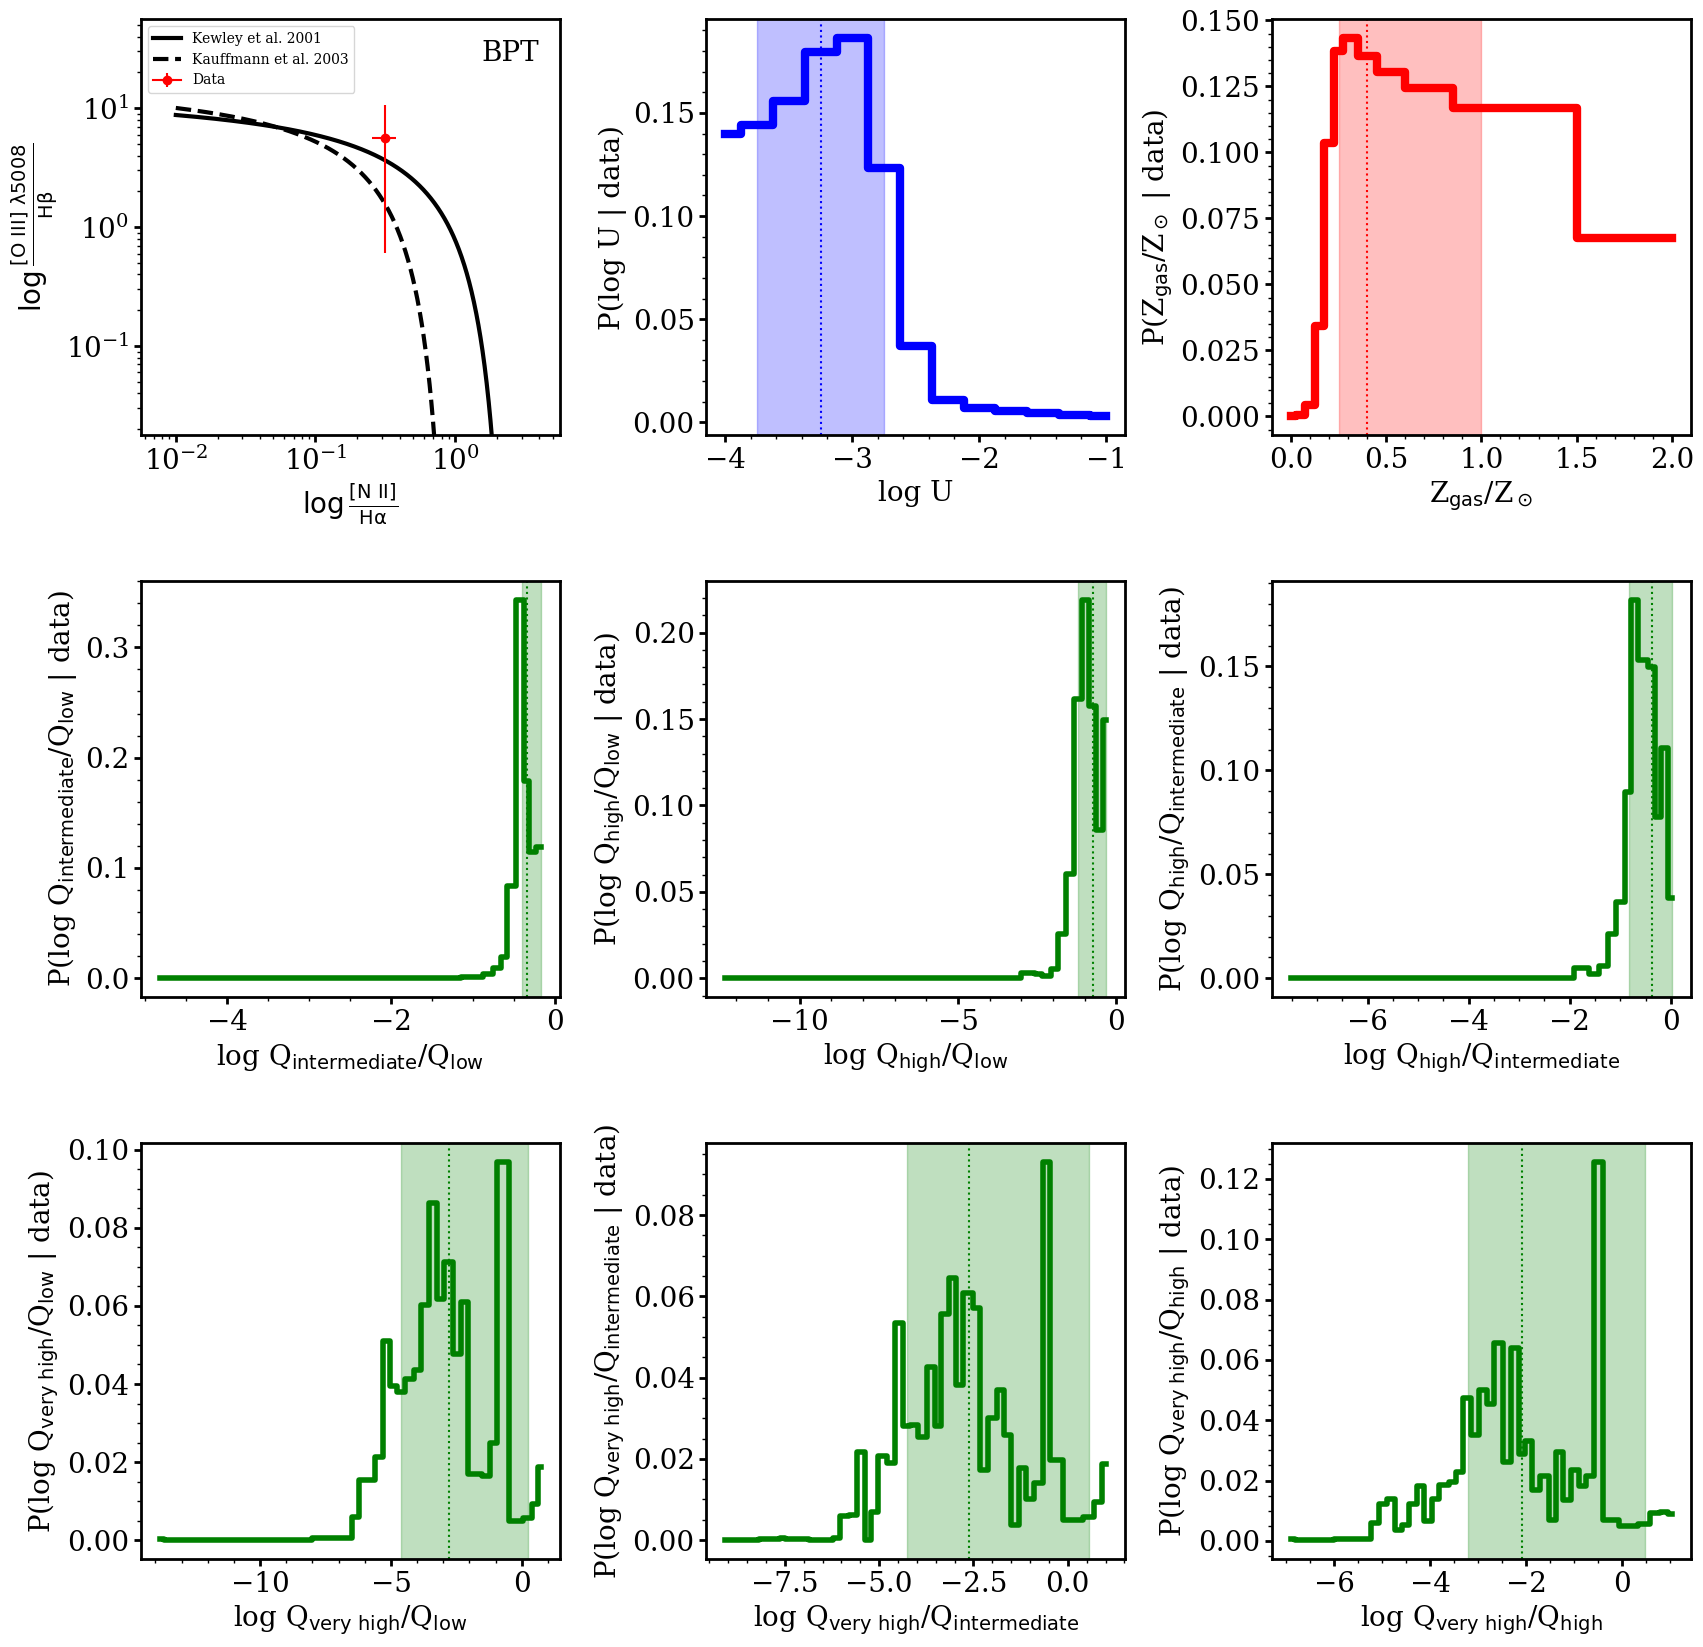

In [404]:
main_bpt(NII_Ha_data=10**-0.5, OIII_Hb_data=10**0.75, NII_Ha_uncertainty=10**-1.2, OIII_Hb_uncertainty=10**0.7)

7.325195562341953e-10

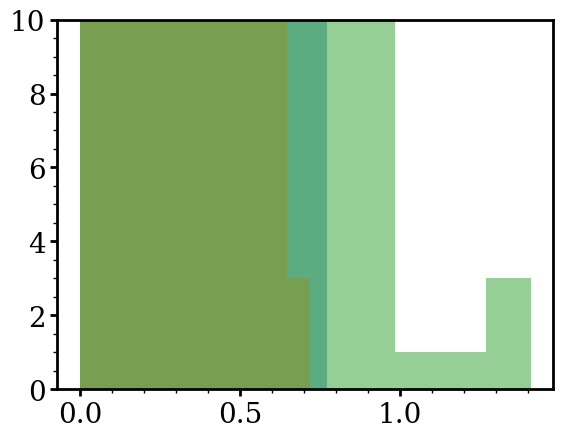

In [392]:
df = make_all_qs(all_models_with_qs)

plt.hist(df['Q_intermediate_Q_low'], alpha=0.5)
plt.hist(df['Q_high_Q_low'], alpha=0.5)
plt.hist(df['Q_high_Q_intermediate'], alpha=0.5)

# plt.hist(df['Q_very_high_Q_low'], alpha=0.5)
# plt.hist(df['Q_very_high_Q_intermediate'], alpha=0.5)
# plt.hist(df['Q_very_high_Q_high'], alpha=0.5)
plt.ylim(0,10)

np.min(df['Q_very_high_Q_intermediate'])


In [291]:
pd.read_csv('mbh_integrals.csv')
pd.read_csv('bpass_all_integrals.csv')


,Unnamed: 0,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,...,10.3,10.4,10.5,10.6,10.7,10.8,10.9,11.0,Z,imf
0,total,2.427434e+09,2.765058e+09,2.967302e+09,3.138716e+09,2.804048e+09,1.724914e+09,1.122225e+09,8.300882e+08,5.533242e+08,...,2.017428,4.442341,8.304223,71.871177,1134.425551,1.756720e+03,4.390630e+01,5.733753e-02,em5,100_300
1,low,1.311085e+09,1.528105e+09,1.665678e+09,1.802671e+09,1.537932e+09,9.665617e+08,6.309305e+08,4.494506e+08,2.867495e+08,...,1.093568,2.584757,5.177152,43.857821,777.292390,1.222680e+03,2.582115e+01,4.512436e-02,em5,100_300
2,intermediate,7.587480e+08,8.694366e+08,9.374181e+08,9.899727e+08,8.705249e+08,5.384860e+08,3.502839e+08,2.559159e+08,1.701913e+08,...,0.567845,0.842460,1.121542,17.632479,327.801318,5.940487e+02,1.262888e+01,2.281742e-03,em5,100_300
3,high,6.874456e+08,7.473763e+08,7.756524e+08,7.778669e+08,7.272761e+08,4.416759e+08,2.879397e+08,2.229976e+08,1.560065e+08,...,0.390365,0.545302,0.798616,14.686670,177.531093,2.346989e+02,1.047521e+01,1.774486e-05,em5,100_300
4,very_high,8.391854e+04,1.370030e+05,2.535904e+05,3.242720e+06,5.002964e+07,1.189334e+07,3.661306e+06,1.091356e+07,1.239868e+07,...,0.104692,0.140545,0.081926,0.005262,5.458687,3.381104e+00,1.552957e-02,1.244810e-08,em5,100_300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,total,4.553469e+08,3.359924e+08,2.823458e+08,2.054321e+08,1.478336e+08,1.301221e+08,6.242261e+07,3.279840e+07,1.975907e+07,...,1780.926848,1063.913275,543.554566,431.896047,1073.798317,2.825627e+02,6.334455e+01,4.170152e+01,040,_chab300
236,low,3.726681e+08,2.709516e+08,2.265453e+08,1.635971e+08,1.171315e+08,1.031195e+08,4.948355e+07,2.481391e+07,1.316826e+07,...,1465.021425,868.820400,459.968119,369.659299,928.868860,2.448502e+02,5.216255e+01,3.393703e+01,040,_chab300
237,intermediate,8.145762e+07,4.257264e+07,3.253934e+07,1.889077e+07,1.158473e+07,2.875899e+07,1.619272e+07,9.365039e+06,6.739965e+06,...,481.910887,189.673918,141.309207,99.408798,252.788184,6.044989e+01,1.225703e+01,7.333397e+00,040,_chab300
238,high,2.518651e+06,8.189900e+05,5.549324e+05,3.603923e+05,4.232866e+05,3.858678e+06,1.987252e+06,1.947517e+06,2.660032e+06,...,69.679339,23.262254,15.528880,8.046781,18.657015,3.545461e+00,1.222232e+00,7.808718e-01,040,_chab300


/opt/miniconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,zstar,age,binary_or_single,history,imf,Q_total,Q_low,Q_intermediate,Q_high,Q_very_high,mbh,Q_intermediate_Q_low,Q_high_Q_low,Q_high_Q_intermediate,Q_very_high_Q_low,Q_very_high_Q_intermediate,Q_very_high_Q_high
73519,NaN,NaN,NaN,NaN,NaN,1.011672e+17,3.774480e+16,1.713501e+16,1.782488e+16,2.834426e+16,7.0,0.453970,0.472247,1.040261,0.750945,1.654172,1.590151
74533,NaN,NaN,NaN,NaN,NaN,1.038155e+18,5.922665e+17,2.368581e+17,1.681249e+17,7.821753e+16,8.0,0.399918,0.283867,0.709813,0.132065,0.330230,0.465235


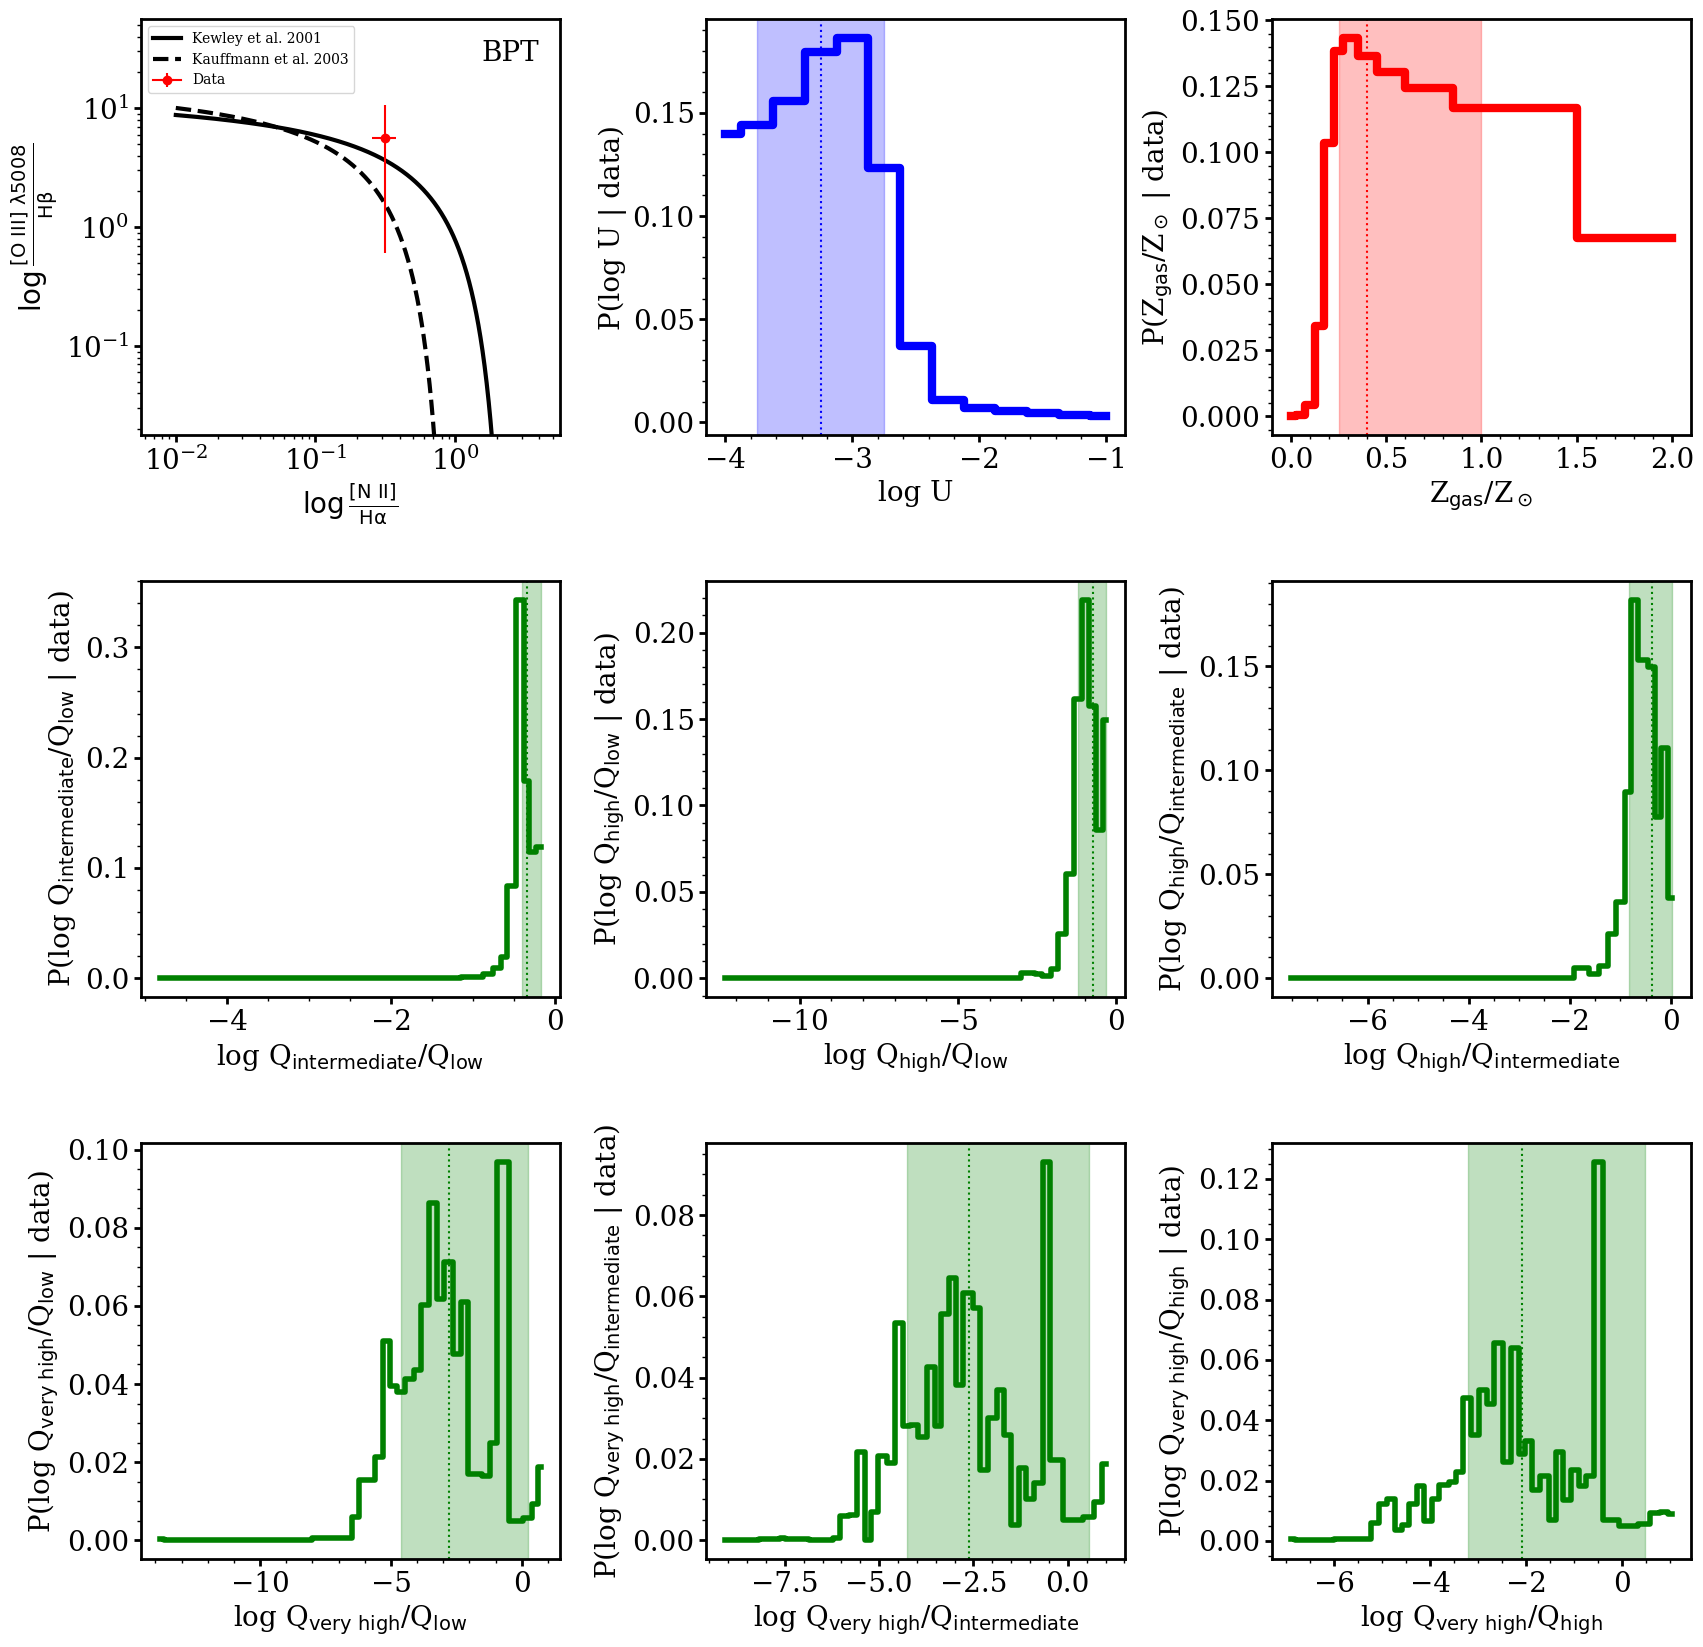

In [406]:
def make_all_qs(all_models_with_qs):
    all_qs = (
        all_models_with_qs.reset_index()[['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh']]
        .drop_duplicates(subset=['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh'], keep='last')
    .assign(
        Q_intermediate_Q_low = lambda x: x.Q_intermediate/x.Q_low,
        Q_high_Q_low = lambda x: x.Q_high/x.Q_low,
        Q_high_Q_intermediate = lambda x: x.Q_high/x.Q_intermediate,
        Q_very_high_Q_low = lambda x: x.Q_very_high/x.Q_low,
        Q_very_high_Q_intermediate = lambda x: x.Q_very_high/x.Q_intermediate,
        Q_very_high_Q_high = lambda x: x.Q_very_high/x.Q_high,
    ))
    return all_qs

def log_likelihood(data, model, uncertainty):
    return -0.5 * (data - model) ** 2 / uncertainty**2


def bpt_kewley_2001(logniiha):
	'''
	Defining the BPT AGN/SF dividing line from Kewley 2001.
	'''    
	return 0.61/(logniiha - 0.47) + 1.19   

    
def plot_bpt_kewley_2001(ax, label=True):
    x = np.linspace(-2,0.46, 1000)
    ax.plot(10**x, 10**bpt_kewley_2001(x), c='black', ls='-', lw=3, label='Kewley et al. 2001' if label else None, zorder=-9)
    

def bpt_kauffmann_2003(logniiha):
	'''
	Defining the BPT AGN/SF dividing line from Kauffmann 2003.
	'''    
	return 0.61/(logniiha - 0.05) + 1.3    
    

def plot_bpt_kauffmann_2003(ax, label=True):
    x = np.linspace(-2,0.04, 1000)
    ax.plot(10**x, 10**bpt_kauffmann_2003(x), c='black', ls='--', lw=3, label='Kauffmann et al. 2003' if label else None, zorder=-9)

    
def calculate_quantile(parameter_array, probability_array, quantile):
    p = parameter_array[np.where(np.cumsum(probability_array) > quantile)[0][0]]
    return p


def calculate_quantiles_16_50_84(parameter_array, probability_array):
    q_16 = calculate_quantile(parameter_array, probability_array, 0.16)
    q_50 = calculate_quantile(parameter_array, probability_array, 0.50)
    q_84 = calculate_quantile(parameter_array, probability_array, 0.84)
    return q_16, q_50, q_84


def calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty):
    NII_Ha_data = np.array([NII_Ha_data])
    OIII_Hb_data = np.array([OIII_Hb_data])
    NII_Ha_uncertainty = np.array([NII_Ha_uncertainty])
    OIII_Hb_uncertainty = np.array([OIII_Hb_uncertainty])
    bpt_inference = pd.DataFrame(index=pd.MultiIndex.from_product([OIII_Hb_data, NII_Ha_data, all_models_with_qs.index], names=['data_OIII_Hb', 'data_NII_Ha', 'sed'])).assign(
        model_OIII = lambda x: [all_models_with_qs.at[sed, 'O_3_5006.84A'] for sed in x.index.get_level_values('sed')],
        model_Hb = lambda x: [all_models_with_qs.at[sed, 'H_1_4861.33A'] for sed in x.index.get_level_values('sed')],
        model_NII = lambda x: [all_models_with_qs.at[sed, 'N_2_6583.45A'] for sed in x.index.get_level_values('sed')],
        model_Ha = lambda x: [all_models_with_qs.at[sed, 'H_1_6562.81A'] for sed in x.index.get_level_values('sed')], 
        logU = lambda x: [all_models_with_qs.at[sed, 'logU'] for sed in x.index.get_level_values('sed')],
        zgas = lambda x: [all_models_with_qs.at[sed, 'zgas'] for sed in x.index.get_level_values('sed')],
        hden = lambda x: [all_models_with_qs.at[sed, 'hden'] for sed in x.index.get_level_values('sed')],
        Q_total = lambda x: [all_models_with_qs.at[sed, 'Q_total'] for sed in x.index.get_level_values('sed')],
        Q_low = lambda x: [all_models_with_qs.at[sed, 'Q_low'] for sed in x.index.get_level_values('sed')],
        Q_intermediate = lambda x: [all_models_with_qs.at[sed, 'Q_intermediate'] for sed in x.index.get_level_values('sed')],
        Q_high = lambda x: [all_models_with_qs.at[sed, 'Q_high'] for sed in x.index.get_level_values('sed')],
        Q_very_high = lambda x: [all_models_with_qs.at[sed, 'Q_very_high'] for sed in x.index.get_level_values('sed')]
        ).reset_index().assign(
        model_OIII_Hb = lambda x: x.model_OIII/x.model_Hb,
        log_model_OIII_Hb = lambda x: np.log10(x.model_OIII_Hb),
        model_NII_Ha = lambda x: x.model_NII/x.model_Ha,
        log_model_NII_Ha = lambda x: np.log10(x.model_NII_Ha),
        log_likelihood_OIII_Hb = lambda x: log_likelihood(data=x.data_OIII_Hb, model=x.model_OIII_Hb, uncertainty=OIII_Hb_uncertainty),
        log_likelihood_NII_Ha = lambda x: log_likelihood(data=x.data_NII_Ha, model=x.model_NII_Ha, uncertainty=NII_Ha_uncertainty), 
        likelihood_BPT = lambda x: np.exp(x.log_likelihood_OIII_Hb+x.log_likelihood_NII_Ha),
        likelihood_BPT_norm = lambda x: x.likelihood_BPT/x.groupby(['data_NII_Ha', 'data_OIII_Hb'])['likelihood_BPT'].transform('sum'),
        likelihood_weighted_logU = lambda x: x.logU*x.likelihood_BPT_norm,
        likelihood_weighted_zgas = lambda x: x.zgas*x.likelihood_BPT_norm,
        likelihood_weighted_Q_total = lambda x: x.Q_total*x.likelihood_BPT_norm,
        likelihood_weighted_Q_low = lambda x: x.Q_low*x.likelihood_BPT_norm,
        likelihood_weighted_Q_intermediate = lambda x: x.Q_intermediate*x.likelihood_BPT_norm,
        likelihood_weighted_Q_high = lambda x: x.Q_high*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high = lambda x: x.Q_very_high*x.likelihood_BPT_norm,
        likelihood_weighted_Q_intermediate_Q_low = lambda x: (x.Q_intermediate/x.Q_low)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_high_Q_intermediate = lambda x:(x.Q_high/x.Q_intermediate)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_high_Q_low = lambda x: (x.Q_high/x.Q_low)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high_Q_low = lambda x: (x.Q_very_high/x.Q_low)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high_Q_intermediate = lambda x: (x.Q_very_high/x.Q_intermediate)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high_Q_high = lambda x: (x.Q_very_high/x.Q_high)*x.likelihood_BPT_norm,
    )
    return bpt_inference


def plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax):
    plot_bpt_kewley_2001(ax, label=True)
    plot_bpt_kauffmann_2003(ax, label=True)
    ax.errorbar(NII_Ha_data, OIII_Hb_data, xerr=NII_Ha_uncertainty, yerr=OIII_Hb_uncertainty, c='red', label='Data', marker='o')
    ax.set_xlim(10**-2.25, 10**0.75)
    ax.set_ylim(10**-1.75, 10**1.75)
    ax.set_xlabel(r'$\log\frac{\rm{[N~II]}}{\rm{H}\alpha}$')
    ax.set_ylabel(r'$\log\frac{\rm{[O~III]}~\lambda5008}{\rm{H}\beta}$')
    ax.annotate('BPT', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')
    ax.legend(fontsize=10)
    ax.set_xscale('log')
    ax.set_yscale('log')


def plot_posterior_logU(bpt_inference_df, ax):
    bpt_groupby_logU = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'logU'], observed=True).sum().reset_index()
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm']) 
    ax.step(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm'], where='mid', lw=6, c='blue')
    ax.axvspan(q_16, q_84, color='blue', alpha=0.25)
    ax.axvline(q_50, c='blue', ls=':')
    ax.set_xlabel('log U')
    ax.set_ylabel('P(log U | data)')


def plot_posterior_Zgas(bpt_inference_df, ax):
    bpt_groupby_zgas = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'zgas'], observed=True).sum().reset_index()
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(bpt_groupby_zgas['zgas'], bpt_groupby_zgas['likelihood_BPT_norm'])
    ax.step(bpt_groupby_zgas['zgas'], bpt_groupby_zgas['likelihood_BPT_norm'], where='mid', lw=6, c='red')
    ax.axvspan(q_16, q_84, color='red', alpha=0.25)
    ax.axvline(q_50, c='red', ls=':')
    ax.set_xlabel(r'Z$_{\rm{gas}}$/Z$_\odot$')
    ax.set_ylabel(r'P(Z$_{\rm{gas}}$/Z$_\odot$ | data)')


def make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_intermediate_Q_low'] = pd.cut(np.log10(bpt_inference_dummy['Q_intermediate']/bpt_inference_dummy['Q_low']), bins=50)
    bpt_inference_dummy['bins_centers_Q_intermediate_Q_low'] = bpt_inference_dummy['bins_Q_intermediate_Q_low'].apply(lambda x: x.mid)
    bpt_groupby_Q_intermediate_Q_low = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_intermediate_Q_low', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_intermediate_Q_low'], observed=True).sum().reset_index()
    return bpt_groupby_Q_intermediate_Q_low


def plot_posterior_Q_intermediate_Q_low(bpt_inference_df, ax):
    bpt_groupby_Q_intermediate_Q_low = make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$ | data)')


def make_bpt_groupby_Q_high_Q_low(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_high_Q_low'] = pd.cut(np.log10(bpt_inference_dummy['Q_high']/bpt_inference_dummy['Q_low']), bins=50)
    bpt_inference_dummy['bins_centers_Q_high_Q_low'] = bpt_inference_dummy['bins_Q_high_Q_low'].apply(lambda x: x.mid)
    bpt_groupby_Q_high_Q_low = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_high_Q_low', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_high_Q_low'], observed=True).sum().reset_index()
    return bpt_groupby_Q_high_Q_low


def plot_posterior_Q_high_Q_low(bpt_inference_df, ax):
    bpt_groupby_Q_high_Q_low = make_bpt_groupby_Q_high_Q_low(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{high}}$/Q$_{\rm{low}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{high}}$/Q$_{\rm{low}}$ | data)')


def make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_high_Q_intermediate'] = pd.cut(np.log10(bpt_inference_dummy['Q_high']/bpt_inference_dummy['Q_intermediate']), bins=50)
    bpt_inference_dummy['bins_centers_Q_high_Q_intermediate'] = bpt_inference_dummy['bins_Q_high_Q_intermediate'].apply(lambda x: x.mid)
    bpt_groupby_Q_high_Q_intermediate = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_high_Q_intermediate', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_high_Q_intermediate'], observed=True).sum().reset_index()
    return bpt_groupby_Q_high_Q_intermediate


def plot_posterior_Q_high_Q_intermediate(bpt_inference_df, ax):
    bpt_groupby_Q_high_Q_intermediate = make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{high}}$/Q$_{\rm{intermediate}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{high}}$/Q$_{\rm{intermediate}}$ | data)')


def make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_low'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_low']), bins=50)
    bpt_inference_dummy['bins_centers_Q_very_high_Q_low'] = bpt_inference_dummy['bins_Q_very_high_Q_low'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_low = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_low', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_low'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_low


def plot_posterior_Q_very_high_Q_low(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_low = make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{very~high}}$/Q$_{\rm{low}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{very~high}}$/Q$_{\rm{low}}$ | data)')


def make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_intermediate'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_intermediate']), bins=50)
    bpt_inference_dummy['bins_centers_Q_very_high_Q_intermediate'] = bpt_inference_dummy['bins_Q_very_high_Q_intermediate'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_intermediate = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_intermediate', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_intermediate'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_intermediate


def plot_posterior_Q_very_high_Q_intermediate(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_intermediate = make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{very~high}}$/Q$_{\rm{intermediate}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{very~high}}$/Q$_{\rm{intermediate}}$ | data)')
    

def make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_high'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_high']), bins=50)
    bpt_inference_dummy['bins_centers_Q_very_high_Q_high'] = bpt_inference_dummy['bins_Q_very_high_Q_high'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_high = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_high', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_high'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_high


def plot_posterior_Q_very_high_Q_high(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_high = make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'], where='mid', lw=4, c='green')
    ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    ax.axvline(q_50, c='green', ls=':')
    ax.set_xlabel(r'log Q$_{\rm{very~high}}$/Q$_{\rm{high}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{very~high}}$/Q$_{\rm{high}}$ | data)')

def make_quantiles_df(bpt_inference_df):
    bpt_groupby_logU = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'logU'], observed=True).sum().reset_index()
    bpt_groupby_zgas = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'zgas'], observed=True).sum().reset_index()
    bpt_groupby_Q_intermediate_Q_low = make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df)
    bpt_groupby_Q_high_Q_low = make_bpt_groupby_Q_high_Q_low(bpt_inference_df)
    bpt_groupby_Q_high_Q_intermediate = make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df)
    bpt_groupby_Q_very_high_Q_low = make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df)
    bpt_groupby_Q_very_high_Q_intermediate = make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df)
    bpt_groupby_Q_very_high_Q_high = make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df)

    data = {
        'logU':calculate_quantiles_16_50_84(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm']), 
        'zgas':calculate_quantiles_16_50_84(bpt_groupby_zgas['zgas'], bpt_groupby_zgas['likelihood_BPT_norm']), 
        'Q_intermediate_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm']),
        'Q_high_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm']),
        'Q_high_Q_intermediate':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm']),
        'Q_very_high_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm']),
        'Q_very_high_Q_intermediate':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm']),
        'Q_very_high_Q_high':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'])
    }

    quantiles_df = pd.DataFrame(data=data, index=['q_16', 'q_50', 'q_84']).T
    return quantiles_df

def find_model_matches(bpt_inference_df, models_df):
    quantiles_df = make_quantiles_df(bpt_inference_df)
    q_conditions = (models_df['Q_intermediate']/models_df['Q_low'] > 10**quantiles_df.loc['Q_intermediate_Q_low', 'q_16'])&\
                   (models_df['Q_intermediate']/models_df['Q_low'] < 10**quantiles_df.loc['Q_intermediate_Q_low', 'q_84'])&\
                   (models_df['Q_high']/models_df['Q_low'] > 10**quantiles_df.loc['Q_high_Q_low', 'q_16'])&\
                   (models_df['Q_high']/models_df['Q_low'] < 10**quantiles_df.loc['Q_high_Q_low', 'q_84'])&\
                   (models_df['Q_high']/models_df['Q_intermediate'] > 10**quantiles_df.loc['Q_high_Q_intermediate', 'q_16'])&\
                   (models_df['Q_high']/models_df['Q_intermediate'] < 10**quantiles_df.loc['Q_high_Q_intermediate', 'q_84'])&\
                   (models_df['Q_very_high']/models_df['Q_low'] > 10**quantiles_df.loc['Q_very_high_Q_low', 'q_16'])&\
                   (models_df['Q_very_high']/models_df['Q_low'] < 10**quantiles_df.loc['Q_very_high_Q_low', 'q_84'])&\
                   (models_df['Q_very_high']/models_df['Q_intermediate'] > 10**quantiles_df.loc['Q_very_high_Q_intermediate', 'q_16'])&\
                   (models_df['Q_very_high']/models_df['Q_intermediate'] < 10**quantiles_df.loc['Q_very_high_Q_intermediate', 'q_84'])&\
                   (models_df['Q_very_high']/models_df['Q_high'] > 10**quantiles_df.loc['Q_very_high_Q_high', 'q_16'])&\
                   (models_df['Q_very_high']/models_df['Q_high'] < 10**quantiles_df.loc['Q_very_high_Q_high', 'q_84'])
                    
    model_matches_df = models_df[q_conditions]
    return model_matches_df


def main_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty):
    bpt_inference_df = calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty)

    fig = plt.figure(figsize=(20,20))
    gs = GridSpec(nrows=3, ncols=3)
    gs.update(wspace=0.35, hspace=0.35)
    ax = fig.add_subplot(gs[0:1, 0:1])
    plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax)
    ax = fig.add_subplot(gs[0:1, 1:2])
    plot_posterior_logU(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[0:1, 2:3])
    plot_posterior_Zgas(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[1:2, 0:1])
    plot_posterior_Q_intermediate_Q_low(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[1:2, 1:2])
    plot_posterior_Q_high_Q_low(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[1:2, 2:3])
    plot_posterior_Q_high_Q_intermediate(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[2:3, 0:1])
    plot_posterior_Q_very_high_Q_low(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[2:3, 1:2])
    plot_posterior_Q_very_high_Q_intermediate(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[2:3, 2:3])
    plot_posterior_Q_very_high_Q_high(bpt_inference_df, ax)

    # display(make_quantiles_df(bpt_inference_df))
    # display(make_all_qs(all_models_with_qs))
    # display(find_model_matches(bpt_inference_df, make_all_qs(all_models_with_qs)))

    matches = find_model_matches(bpt_inference_df, make_all_qs(all_models_with_qs))

    matches_BPASS = matches[matches['mbh'].isna()]
    matches_mbh = matches[matches['mbh'].notna()]


    return matches_mbh

main_bpt(NII_Ha_data=10**-0.5, OIII_Hb_data=10**0.75, NII_Ha_uncertainty=10**-1.2, OIII_Hb_uncertainty=10**0.7)


/opt/miniconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,zstar,age,binary_or_single,history,imf,Q_total,Q_low,Q_intermediate,Q_high,Q_very_high,mbh,Q_intermediate_Q_low,Q_high_Q_low,Q_high_Q_intermediate,Q_very_high_Q_low,Q_very_high_Q_intermediate,Q_very_high_Q_high
39116,1.0000,7.3,binary,burst,170_300,9.676161e+05,6.117506e+05,4.051326e+05,1.529567e+05,8.210872e+02,NaN,0.662251,0.250031,0.377547,0.001342,0.002027,0.005368
39131,0.2000,7.3,binary,burst,170_300,1.665920e+06,1.048241e+06,6.387513e+05,2.935329e+05,1.542125e+03,NaN,0.609355,0.280024,0.459542,0.001471,0.002414,0.005254
39137,0.0050,7.5,binary,burst,170_300,3.510734e+05,2.261099e+05,1.012755e+05,5.997805e+04,8.497539e+02,NaN,0.447904,0.265261,0.592227,0.003758,0.008391,0.014168
39146,0.0005,9.0,binary,burst,170_300,3.912211e+02,2.475428e+02,1.196712e+02,6.915686e+01,7.587679e+00,NaN,0.483436,0.279373,0.577891,0.030652,0.063404,0.109717
39244,0.0500,7.4,binary,burst,170_300,8.761322e+05,5.128846e+05,2.775950e+05,1.968881e+05,3.813768e+03,NaN,0.541243,0.383884,0.709264,0.007436,0.013739,0.019370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72501,0.0005,6.6,binary,burst,100_300,1.122225e+09,6.309305e+08,3.502839e+08,2.879397e+08,3.661306e+06,NaN,0.555186,0.456373,0.822018,0.005803,0.010452,0.012716
72503,0.1500,6.7,binary,burst,100_300,3.668646e+08,2.523652e+08,1.013754e+08,4.980653e+07,7.198913e+05,NaN,0.401701,0.197359,0.491308,0.002853,0.007101,0.014454
72505,1.0000,7.3,binary,burst,100_300,2.794567e+06,1.756946e+06,1.174855e+06,4.506400e+05,2.523268e+03,NaN,0.668692,0.256490,0.383571,0.001436,0.002148,0.005599
73519,NaN,NaN,NaN,NaN,NaN,1.011672e+17,3.774480e+16,1.713501e+16,1.782488e+16,2.834426e+16,7.0,0.453970,0.472247,1.040261,0.750945,1.654172,1.590151


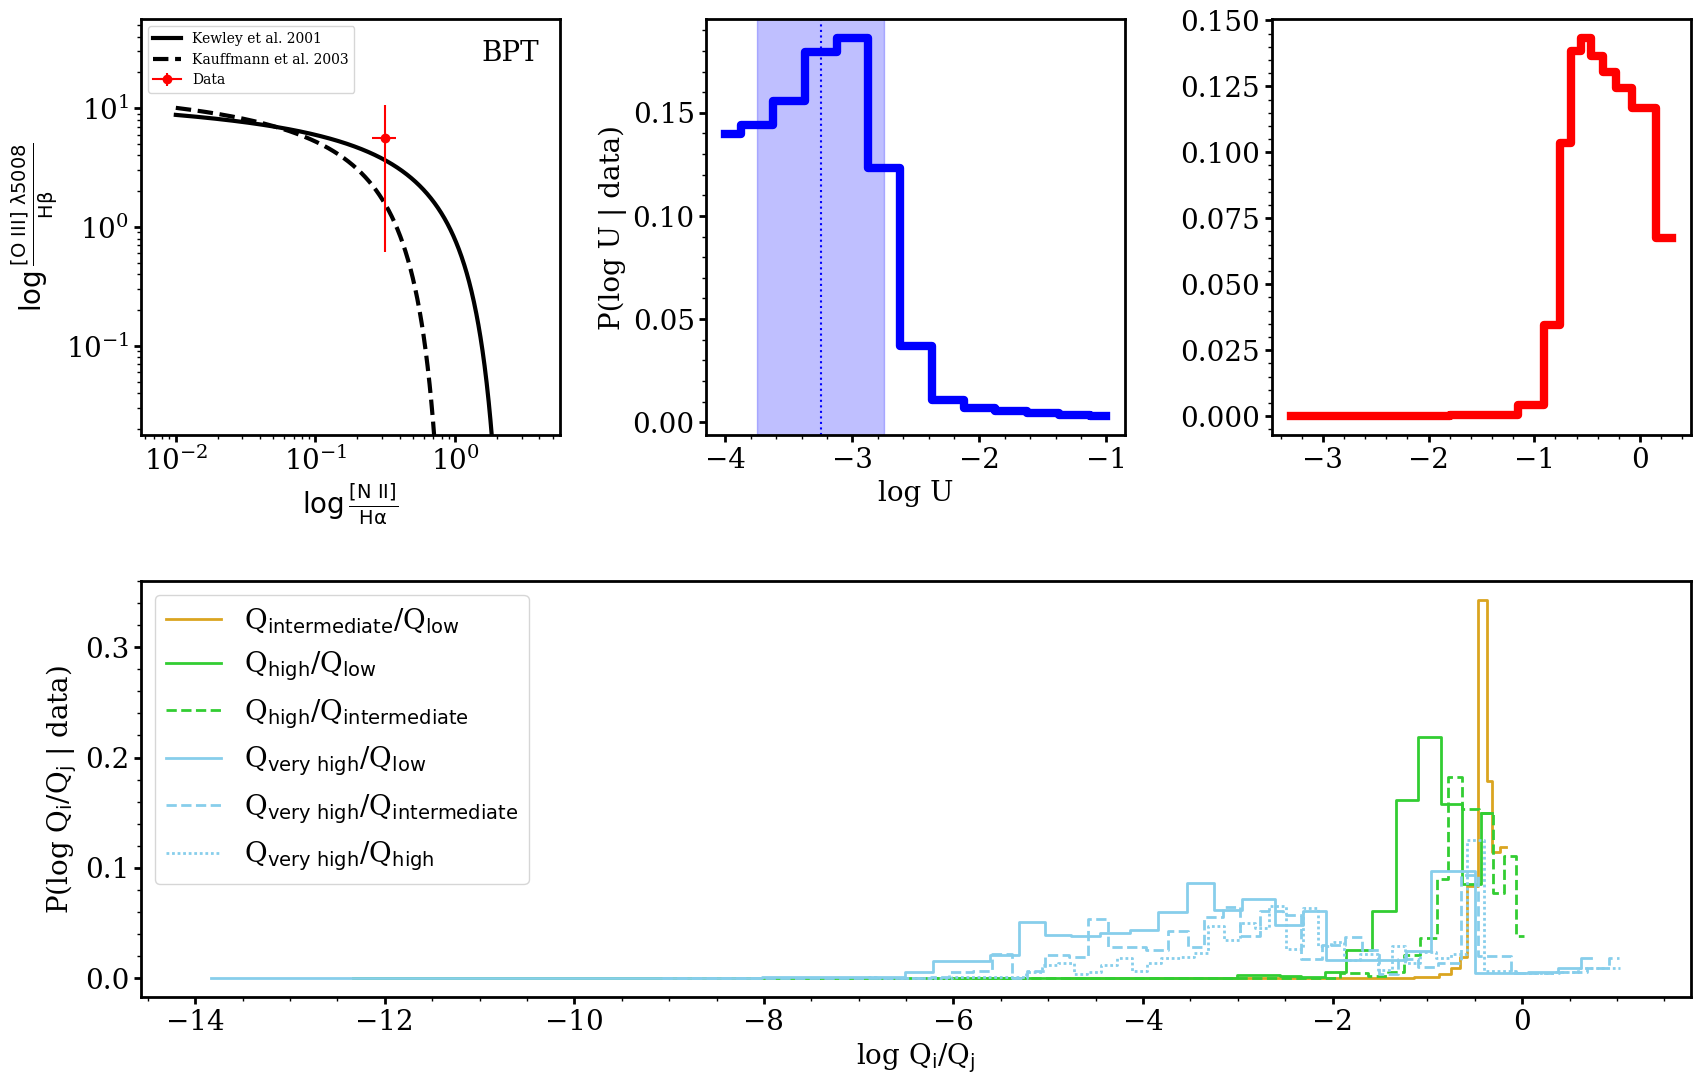

In [426]:
def make_all_qs(all_models_with_qs):
    all_qs = (
        all_models_with_qs.reset_index()[['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh']]
        .drop_duplicates(subset=['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh'], keep='last')
    .assign(
        Q_intermediate_Q_low = lambda x: x.Q_intermediate/x.Q_low,
        Q_high_Q_low = lambda x: x.Q_high/x.Q_low,
        Q_high_Q_intermediate = lambda x: x.Q_high/x.Q_intermediate,
        Q_very_high_Q_low = lambda x: x.Q_very_high/x.Q_low,
        Q_very_high_Q_intermediate = lambda x: x.Q_very_high/x.Q_intermediate,
        Q_very_high_Q_high = lambda x: x.Q_very_high/x.Q_high,
    ))
    return all_qs

def log_likelihood(data, model, uncertainty):
    return -0.5 * (data - model) ** 2 / uncertainty**2


def bpt_kewley_2001(logniiha):
	'''
	Defining the BPT AGN/SF dividing line from Kewley 2001.
	'''    
	return 0.61/(logniiha - 0.47) + 1.19   

    
def plot_bpt_kewley_2001(ax, label=True):
    x = np.linspace(-2,0.46, 1000)
    ax.plot(10**x, 10**bpt_kewley_2001(x), c='black', ls='-', lw=3, label='Kewley et al. 2001' if label else None, zorder=-9)
    

def bpt_kauffmann_2003(logniiha):
	'''
	Defining the BPT AGN/SF dividing line from Kauffmann 2003.
	'''    
	return 0.61/(logniiha - 0.05) + 1.3    
    

def plot_bpt_kauffmann_2003(ax, label=True):
    x = np.linspace(-2,0.04, 1000)
    ax.plot(10**x, 10**bpt_kauffmann_2003(x), c='black', ls='--', lw=3, label='Kauffmann et al. 2003' if label else None, zorder=-9)

    
def calculate_quantile(parameter_array, probability_array, quantile):
    p = parameter_array[np.where(np.cumsum(probability_array) > quantile)[0][0]]
    return p


def calculate_quantiles_16_50_84(parameter_array, probability_array):
    q_16 = calculate_quantile(parameter_array, probability_array, 0.16)
    q_50 = calculate_quantile(parameter_array, probability_array, 0.50)
    q_84 = calculate_quantile(parameter_array, probability_array, 0.84)
    return q_16, q_50, q_84


def calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty):
    NII_Ha_data = np.array([NII_Ha_data])
    OIII_Hb_data = np.array([OIII_Hb_data])
    NII_Ha_uncertainty = np.array([NII_Ha_uncertainty])
    OIII_Hb_uncertainty = np.array([OIII_Hb_uncertainty])
    bpt_inference = pd.DataFrame(index=pd.MultiIndex.from_product([OIII_Hb_data, NII_Ha_data, all_models_with_qs.index], names=['data_OIII_Hb', 'data_NII_Ha', 'sed'])).assign(
        model_OIII = lambda x: [all_models_with_qs.at[sed, 'O_3_5006.84A'] for sed in x.index.get_level_values('sed')],
        model_Hb = lambda x: [all_models_with_qs.at[sed, 'H_1_4861.33A'] for sed in x.index.get_level_values('sed')],
        model_NII = lambda x: [all_models_with_qs.at[sed, 'N_2_6583.45A'] for sed in x.index.get_level_values('sed')],
        model_Ha = lambda x: [all_models_with_qs.at[sed, 'H_1_6562.81A'] for sed in x.index.get_level_values('sed')], 
        logU = lambda x: [all_models_with_qs.at[sed, 'logU'] for sed in x.index.get_level_values('sed')],
        zgas = lambda x: [all_models_with_qs.at[sed, 'zgas'] for sed in x.index.get_level_values('sed')],
        hden = lambda x: [all_models_with_qs.at[sed, 'hden'] for sed in x.index.get_level_values('sed')],
        Q_total = lambda x: [all_models_with_qs.at[sed, 'Q_total'] for sed in x.index.get_level_values('sed')],
        Q_low = lambda x: [all_models_with_qs.at[sed, 'Q_low'] for sed in x.index.get_level_values('sed')],
        Q_intermediate = lambda x: [all_models_with_qs.at[sed, 'Q_intermediate'] for sed in x.index.get_level_values('sed')],
        Q_high = lambda x: [all_models_with_qs.at[sed, 'Q_high'] for sed in x.index.get_level_values('sed')],
        Q_very_high = lambda x: [all_models_with_qs.at[sed, 'Q_very_high'] for sed in x.index.get_level_values('sed')]
        ).reset_index().assign(
        model_OIII_Hb = lambda x: x.model_OIII/x.model_Hb,
        log_model_OIII_Hb = lambda x: np.log10(x.model_OIII_Hb),
        model_NII_Ha = lambda x: x.model_NII/x.model_Ha,
        log_model_NII_Ha = lambda x: np.log10(x.model_NII_Ha),
        log_likelihood_OIII_Hb = lambda x: log_likelihood(data=x.data_OIII_Hb, model=x.model_OIII_Hb, uncertainty=OIII_Hb_uncertainty),
        log_likelihood_NII_Ha = lambda x: log_likelihood(data=x.data_NII_Ha, model=x.model_NII_Ha, uncertainty=NII_Ha_uncertainty), 
        likelihood_BPT = lambda x: np.exp(x.log_likelihood_OIII_Hb+x.log_likelihood_NII_Ha),
        likelihood_BPT_norm = lambda x: x.likelihood_BPT/x.groupby(['data_NII_Ha', 'data_OIII_Hb'])['likelihood_BPT'].transform('sum'),
        likelihood_weighted_logU = lambda x: x.logU*x.likelihood_BPT_norm,
        likelihood_weighted_zgas = lambda x: x.zgas*x.likelihood_BPT_norm,
        likelihood_weighted_Q_total = lambda x: x.Q_total*x.likelihood_BPT_norm,
        likelihood_weighted_Q_low = lambda x: x.Q_low*x.likelihood_BPT_norm,
        likelihood_weighted_Q_intermediate = lambda x: x.Q_intermediate*x.likelihood_BPT_norm,
        likelihood_weighted_Q_high = lambda x: x.Q_high*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high = lambda x: x.Q_very_high*x.likelihood_BPT_norm,
        likelihood_weighted_Q_intermediate_Q_low = lambda x: (x.Q_intermediate/x.Q_low)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_high_Q_intermediate = lambda x:(x.Q_high/x.Q_intermediate)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_high_Q_low = lambda x: (x.Q_high/x.Q_low)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high_Q_low = lambda x: (x.Q_very_high/x.Q_low)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high_Q_intermediate = lambda x: (x.Q_very_high/x.Q_intermediate)*x.likelihood_BPT_norm,
        likelihood_weighted_Q_very_high_Q_high = lambda x: (x.Q_very_high/x.Q_high)*x.likelihood_BPT_norm,
    )
    return bpt_inference


def plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax):
    plot_bpt_kewley_2001(ax, label=True)
    plot_bpt_kauffmann_2003(ax, label=True)
    ax.errorbar(NII_Ha_data, OIII_Hb_data, xerr=NII_Ha_uncertainty, yerr=OIII_Hb_uncertainty, c='red', label='Data', marker='o')
    ax.set_xlim(10**-2.25, 10**0.75)
    ax.set_ylim(10**-1.75, 10**1.75)
    ax.set_xlabel(r'$\log\frac{\rm{[N~II]}}{\rm{H}\alpha}$')
    ax.set_ylabel(r'$\log\frac{\rm{[O~III]}~\lambda5008}{\rm{H}\beta}$')
    ax.annotate('BPT', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')
    ax.legend(fontsize=10)
    ax.set_xscale('log')
    ax.set_yscale('log')


def plot_posterior_logU(bpt_inference_df, ax):
    bpt_groupby_logU = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'logU'], observed=True).sum().reset_index()
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm']) 
    ax.step(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm'], where='mid', lw=6, c='blue')
    ax.axvspan(q_16, q_84, color='blue', alpha=0.25)
    ax.axvline(q_50, c='blue', ls=':')
    ax.set_xlabel('log U')
    ax.set_ylabel('P(log U | data)')


def plot_posterior_Zgas(bpt_inference_df, ax):
    bpt_groupby_zgas = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'zgas'], observed=True).sum().reset_index()
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(bpt_groupby_zgas['zgas'], bpt_groupby_zgas['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_zgas['zgas']), bpt_groupby_zgas['likelihood_BPT_norm'], where='mid', lw=6, c='red')
    # ax.axvspan(q_16, q_84, color='red', alpha=0.25)
    # ax.axvline(q_50, c='red', ls=':')
    # ax.set_xlabel(r'Z$_{\rm{gas}}$/Z$_\odot$')
    # ax.set_ylabel(r'P(Z$_{\rm{gas}}$/Z$_\odot$ | data)')


def make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_intermediate_Q_low'] = pd.cut(np.log10(bpt_inference_dummy['Q_intermediate']/bpt_inference_dummy['Q_low']), bins=50)
    bpt_inference_dummy['bins_centers_Q_intermediate_Q_low'] = bpt_inference_dummy['bins_Q_intermediate_Q_low'].apply(lambda x: x.mid)
    bpt_groupby_Q_intermediate_Q_low = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_intermediate_Q_low', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_intermediate_Q_low'], observed=True).sum().reset_index()
    return bpt_groupby_Q_intermediate_Q_low


def plot_posterior_Q_intermediate_Q_low(bpt_inference_df, ax):
    bpt_groupby_Q_intermediate_Q_low = make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df)
    # q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{intermediate}}$/Q$_{\rm{low}}$', ls='-', c='goldenrod')
    # ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    # ax.axvline(q_50, c='green', ls=':')


def make_bpt_groupby_Q_high_Q_low(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_high_Q_low'] = pd.cut(np.log10(bpt_inference_dummy['Q_high']/bpt_inference_dummy['Q_low']), bins=50)
    bpt_inference_dummy['bins_centers_Q_high_Q_low'] = bpt_inference_dummy['bins_Q_high_Q_low'].apply(lambda x: x.mid)
    bpt_groupby_Q_high_Q_low = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_high_Q_low', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_high_Q_low'], observed=True).sum().reset_index()
    return bpt_groupby_Q_high_Q_low


def plot_posterior_Q_high_Q_low(bpt_inference_df, ax):
    bpt_groupby_Q_high_Q_low = make_bpt_groupby_Q_high_Q_low(bpt_inference_df)
    # q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{high}}$/Q$_{\rm{low}}$', ls='-', c='limegreen')
    # ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    # ax.axvline(q_50, c='green', ls=':')
    # ax.set_xlabel(r'log Q$_{\rm{high}}$/Q$_{\rm{low}}$')
    # ax.set_ylabel(r'P(log Q$_{\rm{high}}$/Q$_{\rm{low}}$ | data)')


def make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_high_Q_intermediate'] = pd.cut(np.log10(bpt_inference_dummy['Q_high']/bpt_inference_dummy['Q_intermediate']), bins=50)
    bpt_inference_dummy['bins_centers_Q_high_Q_intermediate'] = bpt_inference_dummy['bins_Q_high_Q_intermediate'].apply(lambda x: x.mid)
    bpt_groupby_Q_high_Q_intermediate = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_high_Q_intermediate', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_high_Q_intermediate'], observed=True).sum().reset_index()
    return bpt_groupby_Q_high_Q_intermediate


def plot_posterior_Q_high_Q_intermediate(bpt_inference_df, ax):
    bpt_groupby_Q_high_Q_intermediate = make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df)
    # q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{high}}$/Q$_{\rm{intermediate}}$', ls='--', c='limegreen')
    # ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    # ax.axvline(q_50, c='green', ls=':')
    # ax.set_xlabel(r'log Q$_{\rm{high}}$/Q$_{\rm{intermediate}}$')
    # ax.set_ylabel(r'P(log Q$_{\rm{high}}$/Q$_{\rm{intermediate}}$ | data)')


def make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_low'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_low']), bins=50)
    bpt_inference_dummy['bins_centers_Q_very_high_Q_low'] = bpt_inference_dummy['bins_Q_very_high_Q_low'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_low = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_low', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_low'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_low


def plot_posterior_Q_very_high_Q_low(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_low = make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{very~high}}$/Q$_{\rm{low}}$', ls='-', c='skyblue')
    # ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    # ax.axvline(q_50, c='green', ls=':')
    # ax.set_xlabel(r'log Q$_{\rm{very~high}}$/Q$_{\rm{low}}$')
    # ax.set_ylabel(r'P(log Q$_{\rm{very~high}}$/Q$_{\rm{low}}$ | data)')


def make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_intermediate'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_intermediate']), bins=50)
    bpt_inference_dummy['bins_centers_Q_very_high_Q_intermediate'] = bpt_inference_dummy['bins_Q_very_high_Q_intermediate'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_intermediate = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_intermediate', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_intermediate'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_intermediate


def plot_posterior_Q_very_high_Q_intermediate(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_intermediate = make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{very~high}}$/Q$_{\rm{intermediate}}$', ls='--', c='skyblue')
    # ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    # ax.axvline(q_50, c='green', ls=':')
    # ax.set_xlabel(r'log Q$_{\rm{very~high}}$/Q$_{\rm{intermediate}}$')
    # ax.set_ylabel(r'P(log Q$_{\rm{very~high}}$/Q$_{\rm{intermediate}}$ | data)')
    

def make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_high'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_high']), bins=50)
    bpt_inference_dummy['bins_centers_Q_very_high_Q_high'] = bpt_inference_dummy['bins_Q_very_high_Q_high'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_high = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_high', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_high'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_high


def plot_posterior_Q_very_high_Q_high(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_high = make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df)
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{very~high}}$/Q$_{\rm{high}}$', ls=(0, (1, 1)), c='skyblue')
    # ax.axvspan(q_16, q_84, color='green', alpha=0.25)
    # ax.axvline(q_50, c='green', ls=':')
    # ax.set_xlabel(r'log Q$_{\rm{very~high}}$/Q$_{\rm{high}}$')
    # ax.set_ylabel(r'P(log Q$_{\rm{very~high}}$/Q$_{\rm{high}}$ | data)')

def plot_posterior_all_Q(bpt_inference_df, ax):
    plot_posterior_Q_intermediate_Q_low(bpt_inference_df, ax)
    plot_posterior_Q_high_Q_low(bpt_inference_df, ax)
    plot_posterior_Q_high_Q_intermediate(bpt_inference_df, ax)
    plot_posterior_Q_very_high_Q_low(bpt_inference_df, ax)
    plot_posterior_Q_very_high_Q_intermediate(bpt_inference_df, ax)
    plot_posterior_Q_very_high_Q_high(bpt_inference_df, ax)
    ax.set_xlabel(r'log Q$_{\rm{i}}$/Q$_{\rm{j}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{i}}$/Q$_{\rm{j}}$ | data)')
    ax.legend()

def make_quantiles_df(bpt_inference_df):
    bpt_groupby_logU = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'logU'], observed=True).sum().reset_index()
    bpt_groupby_zgas = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'zgas'], observed=True).sum().reset_index()
    bpt_groupby_Q_intermediate_Q_low = make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df)
    bpt_groupby_Q_high_Q_low = make_bpt_groupby_Q_high_Q_low(bpt_inference_df)
    bpt_groupby_Q_high_Q_intermediate = make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df)
    bpt_groupby_Q_very_high_Q_low = make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df)
    bpt_groupby_Q_very_high_Q_intermediate = make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df)
    bpt_groupby_Q_very_high_Q_high = make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df)

    data = {
        'logU':calculate_quantiles_16_50_84(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm']), 
        'zgas':calculate_quantiles_16_50_84(bpt_groupby_zgas['zgas'], bpt_groupby_zgas['likelihood_BPT_norm']), 
        'Q_intermediate_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm']),
        'Q_high_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm']),
        'Q_high_Q_intermediate':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm']),
        'Q_very_high_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm']),
        'Q_very_high_Q_intermediate':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm']),
        'Q_very_high_Q_high':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'])
    }

    quantiles_df = pd.DataFrame(data=data, index=['q_16', 'q_50', 'q_84']).T
    return quantiles_df

def find_model_matches(bpt_inference_df, models_df):
    quantiles_df = make_quantiles_df(bpt_inference_df)
    q_conditions = (models_df['Q_intermediate']/models_df['Q_low'] > 10**quantiles_df.loc['Q_intermediate_Q_low', 'q_16'])&\
                   (models_df['Q_intermediate']/models_df['Q_low'] < 10**quantiles_df.loc['Q_intermediate_Q_low', 'q_84'])&\
                   (models_df['Q_high']/models_df['Q_low'] > 10**quantiles_df.loc['Q_high_Q_low', 'q_16'])&\
                   (models_df['Q_high']/models_df['Q_low'] < 10**quantiles_df.loc['Q_high_Q_low', 'q_84'])&\
                   (models_df['Q_high']/models_df['Q_intermediate'] > 10**quantiles_df.loc['Q_high_Q_intermediate', 'q_16'])&\
                   (models_df['Q_high']/models_df['Q_intermediate'] < 10**quantiles_df.loc['Q_high_Q_intermediate', 'q_84'])&\
                   (models_df['Q_very_high']/models_df['Q_low'] > 10**quantiles_df.loc['Q_very_high_Q_low', 'q_16'])&\
                   (models_df['Q_very_high']/models_df['Q_low'] < 10**quantiles_df.loc['Q_very_high_Q_low', 'q_84'])&\
                   (models_df['Q_very_high']/models_df['Q_intermediate'] > 10**quantiles_df.loc['Q_very_high_Q_intermediate', 'q_16'])&\
                   (models_df['Q_very_high']/models_df['Q_intermediate'] < 10**quantiles_df.loc['Q_very_high_Q_intermediate', 'q_84'])&\
                   (models_df['Q_very_high']/models_df['Q_high'] > 10**quantiles_df.loc['Q_very_high_Q_high', 'q_16'])&\
                   (models_df['Q_very_high']/models_df['Q_high'] < 10**quantiles_df.loc['Q_very_high_Q_high', 'q_84'])
                    
    model_matches_df = models_df[q_conditions]
    return model_matches_df


def main_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty):
    bpt_inference_df = calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty)

    fig = plt.figure(figsize=(20,20))
    gs = GridSpec(nrows=3, ncols=3)
    gs.update(wspace=0.35, hspace=0.35)
    ax = fig.add_subplot(gs[0:1, 0:1])
    plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax)
    ax = fig.add_subplot(gs[0:1, 1:2])
    plot_posterior_logU(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[0:1, 2:3])
    plot_posterior_Zgas(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[1:2, 0:3])
    plot_posterior_all_Q(bpt_inference_df, ax)
    # display(make_quantiles_df(bpt_inference_df))
    # display(make_all_qs(all_models_with_qs))
    # display(find_model_matches(bpt_inference_df, make_all_qs(all_models_with_qs)))

    matches = find_model_matches(bpt_inference_df, make_all_qs(all_models_with_qs))

    matches_BPASS = matches[matches['mbh'].isna()]
    matches_mbh = matches[matches['mbh'].notna()]


    return matches

main_bpt(NII_Ha_data=10**-0.5, OIII_Hb_data=10**0.75, NII_Ha_uncertainty=10**-1.2, OIII_Hb_uncertainty=10**0.7)


/opt/miniconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


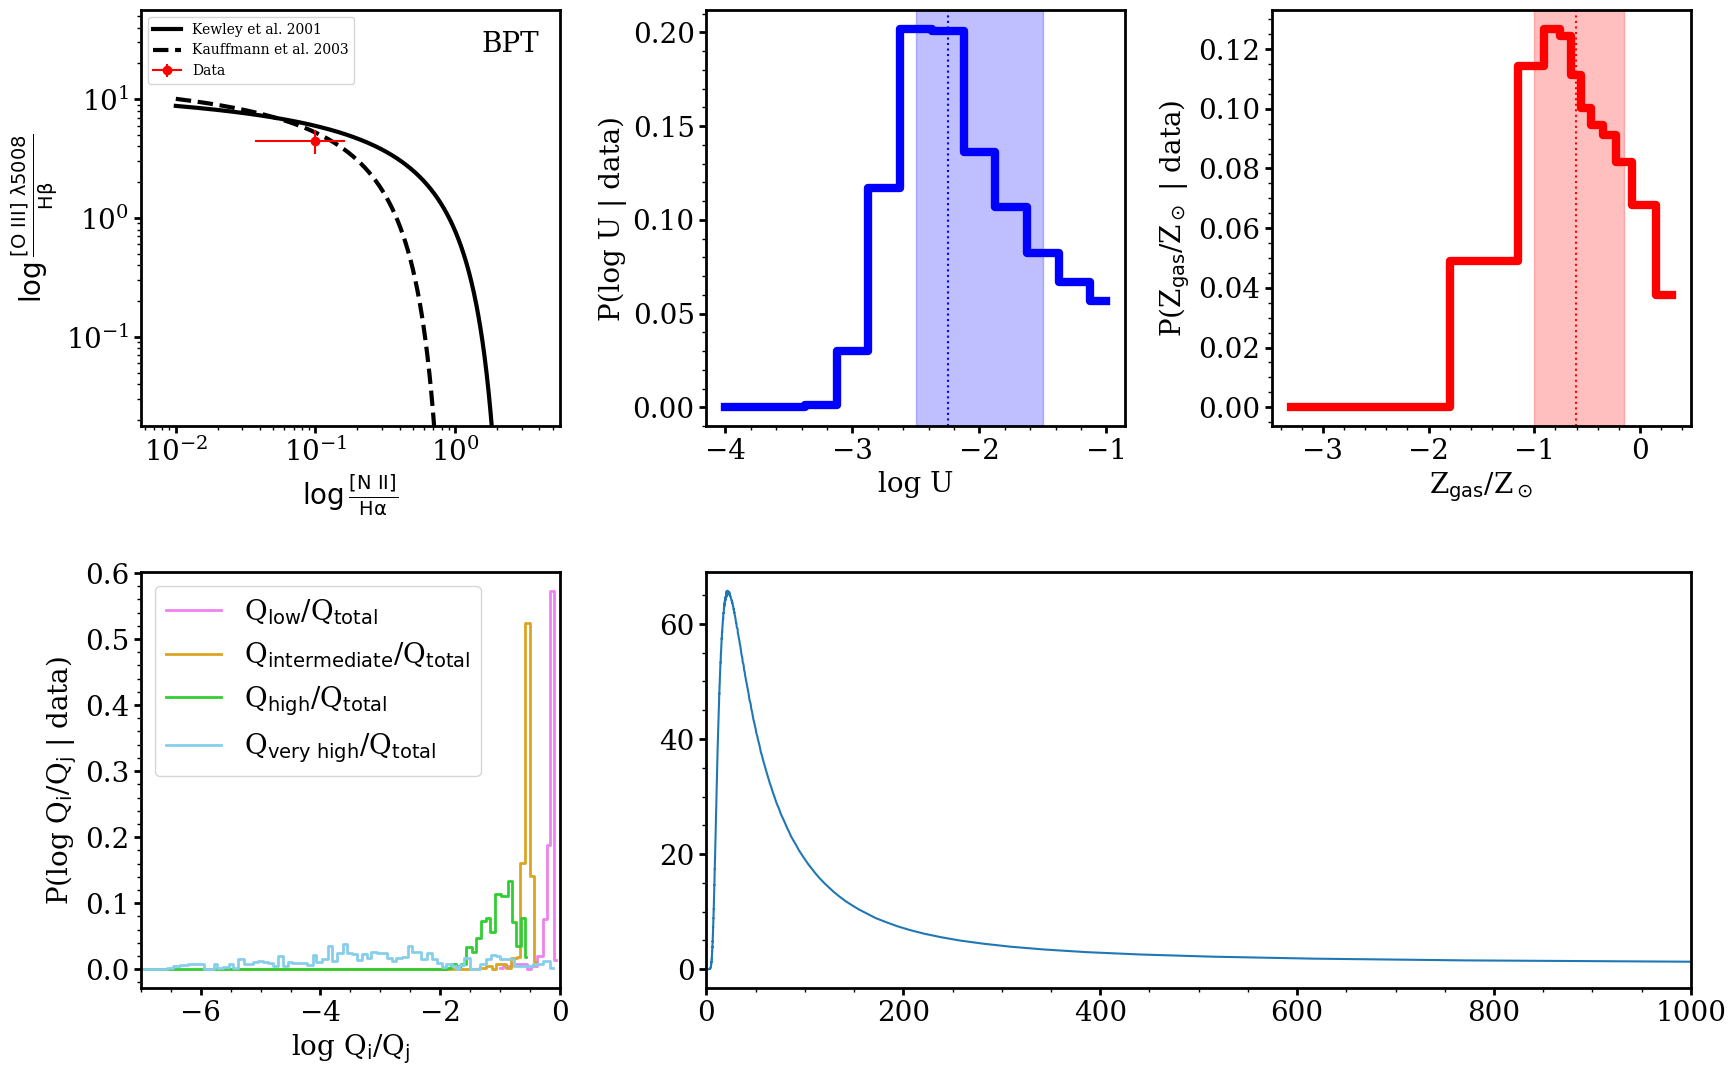

In [5]:
def make_all_qs(all_models_with_qs):
    all_qs = (
        all_models_with_qs.reset_index()[['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh']]
        .drop_duplicates(subset=['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh'], keep='last')
    .assign(
        Q_intermediate_Q_low = lambda x: x.Q_intermediate/x.Q_low,
        Q_high_Q_low = lambda x: x.Q_high/x.Q_low,
        Q_high_Q_intermediate = lambda x: x.Q_high/x.Q_intermediate,
        Q_very_high_Q_low = lambda x: x.Q_very_high/x.Q_low,
        Q_very_high_Q_intermediate = lambda x: x.Q_very_high/x.Q_intermediate,
        Q_very_high_Q_high = lambda x: x.Q_very_high/x.Q_high,
    ))
    return all_qs

def log_likelihood(data, model, uncertainty):
    return -0.5 * (data - model) ** 2 / uncertainty**2


def bpt_kewley_2001(logniiha):
	'''
	Defining the BPT AGN/SF dividing line from Kewley 2001.
	'''    
	return 0.61/(logniiha - 0.47) + 1.19   

    
def plot_bpt_kewley_2001(ax, label=True):
    x = np.linspace(-2,0.46, 1000)
    ax.plot(10**x, 10**bpt_kewley_2001(x), c='black', ls='-', lw=3, label='Kewley et al. 2001' if label else None, zorder=-9)
    

def bpt_kauffmann_2003(logniiha):
	'''
	Defining the BPT AGN/SF dividing line from Kauffmann 2003.
	'''    
	return 0.61/(logniiha - 0.05) + 1.3    
    

def plot_bpt_kauffmann_2003(ax, label=True):
    x = np.linspace(-2,0.04, 1000)
    ax.plot(10**x, 10**bpt_kauffmann_2003(x), c='black', ls='--', lw=3, label='Kauffmann et al. 2003' if label else None, zorder=-9)

    
def calculate_quantile(parameter_array, probability_array, quantile):
    p = parameter_array[np.where(np.cumsum(probability_array) > quantile)[0][0]]
    return p


def calculate_quantiles_16_50_84(parameter_array, probability_array):
    q_16 = calculate_quantile(parameter_array, probability_array, 0.16)
    q_50 = calculate_quantile(parameter_array, probability_array, 0.50)
    q_84 = calculate_quantile(parameter_array, probability_array, 0.84)
    return q_16, q_50, q_84


def calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty):
    NII_Ha_data = np.array([NII_Ha_data])
    OIII_Hb_data = np.array([OIII_Hb_data])
    NII_Ha_uncertainty = np.array([NII_Ha_uncertainty])
    OIII_Hb_uncertainty = np.array([OIII_Hb_uncertainty])
    bpt_inference = pd.DataFrame(index=pd.MultiIndex.from_product([OIII_Hb_data, NII_Ha_data, all_models_with_qs.index], names=['data_OIII_Hb', 'data_NII_Ha', 'sed'])).assign(
        model_OIII = lambda x: [all_models_with_qs.at[sed, 'O_3_5006.84A'] for sed in x.index.get_level_values('sed')],
        model_Hb = lambda x: [all_models_with_qs.at[sed, 'H_1_4861.33A'] for sed in x.index.get_level_values('sed')],
        model_NII = lambda x: [all_models_with_qs.at[sed, 'N_2_6583.45A'] for sed in x.index.get_level_values('sed')],
        model_Ha = lambda x: [all_models_with_qs.at[sed, 'H_1_6562.81A'] for sed in x.index.get_level_values('sed')], 
        logU = lambda x: [all_models_with_qs.at[sed, 'logU'] for sed in x.index.get_level_values('sed')],
        zgas = lambda x: [all_models_with_qs.at[sed, 'zgas'] for sed in x.index.get_level_values('sed')],
        hden = lambda x: [all_models_with_qs.at[sed, 'hden'] for sed in x.index.get_level_values('sed')],
        Q_total = lambda x: [all_models_with_qs.at[sed, 'Q_total'] for sed in x.index.get_level_values('sed')],
        Q_low = lambda x: [all_models_with_qs.at[sed, 'Q_low'] for sed in x.index.get_level_values('sed')],
        Q_intermediate = lambda x: [all_models_with_qs.at[sed, 'Q_intermediate'] for sed in x.index.get_level_values('sed')],
        Q_high = lambda x: [all_models_with_qs.at[sed, 'Q_high'] for sed in x.index.get_level_values('sed')],
        Q_very_high = lambda x: [all_models_with_qs.at[sed, 'Q_very_high'] for sed in x.index.get_level_values('sed')]
        ).reset_index().assign(
        model_OIII_Hb = lambda x: x.model_OIII/x.model_Hb,
        log_model_OIII_Hb = lambda x: np.log10(x.model_OIII_Hb),
        model_NII_Ha = lambda x: x.model_NII/x.model_Ha,
        log_model_NII_Ha = lambda x: np.log10(x.model_NII_Ha),
        log_likelihood_OIII_Hb = lambda x: log_likelihood(data=x.data_OIII_Hb, model=x.model_OIII_Hb, uncertainty=OIII_Hb_uncertainty),
        log_likelihood_NII_Ha = lambda x: log_likelihood(data=x.data_NII_Ha, model=x.model_NII_Ha, uncertainty=NII_Ha_uncertainty), 
        likelihood_BPT = lambda x: np.exp(x.log_likelihood_OIII_Hb+x.log_likelihood_NII_Ha),
        likelihood_BPT_norm = lambda x: x.likelihood_BPT/x.groupby(['data_NII_Ha', 'data_OIII_Hb'])['likelihood_BPT'].transform('sum'),
    )
    return bpt_inference


def plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax):
    plot_bpt_kewley_2001(ax, label=True)
    plot_bpt_kauffmann_2003(ax, label=True)
    ax.errorbar(NII_Ha_data, OIII_Hb_data, xerr=NII_Ha_uncertainty, yerr=OIII_Hb_uncertainty, c='red', label='Data', marker='o')
    ax.set_xlim(10**-2.25, 10**0.75)
    ax.set_ylim(10**-1.75, 10**1.75)
    ax.set_xlabel(r'$\log\frac{\rm{[N~II]}}{\rm{H}\alpha}$')
    ax.set_ylabel(r'$\log\frac{\rm{[O~III]}~\lambda5008}{\rm{H}\beta}$')
    ax.annotate('BPT', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')
    ax.legend(fontsize=10)
    ax.set_xscale('log')
    ax.set_yscale('log')


def plot_posterior_logU(bpt_inference_df, ax):
    bpt_groupby_logU = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'logU'], observed=True).sum().reset_index()
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm']) 
    ax.step(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm'], where='mid', lw=6, c='blue')
    ax.axvspan(q_16, q_84, color='blue', alpha=0.25)
    ax.axvline(q_50, c='blue', ls=':')
    ax.set_xlabel('log U')
    ax.set_ylabel('P(log U | data)')


def plot_posterior_Zgas(bpt_inference_df, ax):
    bpt_groupby_zgas = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'zgas'], observed=True).sum().reset_index()
    q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_zgas['zgas']), bpt_groupby_zgas['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_zgas['zgas']), bpt_groupby_zgas['likelihood_BPT_norm'], where='mid', lw=6, c='red')
    ax.axvspan(q_16, q_84, color='red', alpha=0.25)
    ax.axvline(q_50, c='red', ls=':')
    ax.set_xlabel(r'Z$_{\rm{gas}}$/Z$_\odot$')
    ax.set_ylabel(r'P(Z$_{\rm{gas}}$/Z$_\odot$ | data)')


def make_bpt_groupby_Q_low_Q_total(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_low_Q_total'] = pd.cut(np.log10(bpt_inference_dummy['Q_low']/bpt_inference_dummy['Q_total']), bins=np.linspace(-15, 1.5, 200))
    bpt_inference_dummy['bins_centers_Q_low_Q_total'] = bpt_inference_dummy['bins_Q_low_Q_total'].apply(lambda x: x.mid)
    bpt_groupby_Q_low_Q_total = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_low_Q_total', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_low_Q_total'], observed=True).sum().reset_index()
    return bpt_groupby_Q_low_Q_total


def plot_posterior_Q_low_Q_total(bpt_inference_df, ax):
    bpt_groupby_Q_low_Q_total = make_bpt_groupby_Q_low_Q_total(bpt_inference_df)
    ax.step(np.log10(bpt_groupby_Q_low_Q_total['Q_low']/bpt_groupby_Q_low_Q_total['Q_total']), bpt_groupby_Q_low_Q_total['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{low}}$/Q$_{\rm{total}}$', ls='-', c='violet')


def make_bpt_groupby_Q_intermediate_Q_total(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_intermediate_Q_total'] = pd.cut(np.log10(bpt_inference_dummy['Q_intermediate']/bpt_inference_dummy['Q_total']), bins=np.linspace(-15, 1.5, 200))
    bpt_inference_dummy['bins_centers_Q_intermediate_Q_total'] = bpt_inference_dummy['bins_Q_intermediate_Q_total'].apply(lambda x: x.mid)
    bpt_groupby_Q_intermediate_Q_total = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_intermediate_Q_total', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_intermediate_Q_total'], observed=True).sum().reset_index()
    return bpt_groupby_Q_intermediate_Q_total


def plot_posterior_Q_intermediate_Q_total(bpt_inference_df, ax):
    bpt_groupby_Q_intermediate_Q_total = make_bpt_groupby_Q_intermediate_Q_total(bpt_inference_df)
    ax.step(np.log10(bpt_groupby_Q_intermediate_Q_total['Q_intermediate']/bpt_groupby_Q_intermediate_Q_total['Q_total']), bpt_groupby_Q_intermediate_Q_total['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{intermediate}}$/Q$_{\rm{total}}$', ls='-', c='goldenrod')


def make_bpt_groupby_Q_high_Q_total(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_high_Q_total'] = pd.cut(np.log10(bpt_inference_dummy['Q_high']/bpt_inference_dummy['Q_total']), bins=np.linspace(-15, 1.5, 200))
    bpt_inference_dummy['bins_centers_Q_high_Q_total'] = bpt_inference_dummy['bins_Q_high_Q_total'].apply(lambda x: x.mid)
    bpt_groupby_Q_high_Q_total = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_high_Q_total', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_high_Q_total'], observed=True).sum().reset_index()
    return bpt_groupby_Q_high_Q_total


def plot_posterior_Q_high_Q_total(bpt_inference_df, ax):
    bpt_groupby_Q_high_Q_total = make_bpt_groupby_Q_high_Q_total(bpt_inference_df)
    ax.step(np.log10(bpt_groupby_Q_high_Q_total['Q_high']/bpt_groupby_Q_high_Q_total['Q_total']), bpt_groupby_Q_high_Q_total['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{high}}$/Q$_{\rm{total}}$', ls='-', c='limegreen')

def make_bpt_groupby_Q_very_high_Q_total(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_total'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_total']), bins=np.linspace(-15, 1.5, 200))
    bpt_inference_dummy['bins_centers_Q_very_high_Q_total'] = bpt_inference_dummy['bins_Q_very_high_Q_total'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_total = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_total', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_total'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_total


def plot_posterior_Q_very_high_Q_total(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_total = make_bpt_groupby_Q_very_high_Q_total(bpt_inference_df)
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_total['Q_very_high']/bpt_groupby_Q_very_high_Q_total['Q_total']), bpt_groupby_Q_very_high_Q_total['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{very~high}}$/Q$_{\rm{total}}$', ls='-', c='skyblue')

def plot_posterior_all_Q(bpt_inference_df, ax):
    plot_posterior_Q_low_Q_total(bpt_inference_df, ax)
    plot_posterior_Q_intermediate_Q_total(bpt_inference_df, ax)
    plot_posterior_Q_high_Q_total(bpt_inference_df, ax)
    plot_posterior_Q_very_high_Q_total(bpt_inference_df, ax)
    ax.set_xlabel(r'log Q$_{\rm{i}}$/Q$_{\rm{j}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{i}}$/Q$_{\rm{j}}$ | data)')
    ax.set_xlim(-7, 0)
    ax.legend()

# def make_quantiles_df(bpt_inference_df):
#     bpt_groupby_logU = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'logU'], observed=True).sum().reset_index()
#     bpt_groupby_zgas = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'zgas'], observed=True).sum().reset_index()
#     bpt_groupby_Q_intermediate_Q_low = make_bpt_groupby_Q_intermediate_Q_low(bpt_inference_df)
#     bpt_groupby_Q_high_Q_low = make_bpt_groupby_Q_high_Q_low(bpt_inference_df)
#     bpt_groupby_Q_high_Q_intermediate = make_bpt_groupby_Q_high_Q_intermediate(bpt_inference_df)
#     bpt_groupby_Q_very_high_Q_low = make_bpt_groupby_Q_very_high_Q_low(bpt_inference_df)
#     bpt_groupby_Q_very_high_Q_intermediate = make_bpt_groupby_Q_very_high_Q_intermediate(bpt_inference_df)
#     bpt_groupby_Q_very_high_Q_high = make_bpt_groupby_Q_very_high_Q_high(bpt_inference_df)

#     data = {
#         'logU':calculate_quantiles_16_50_84(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm']), 
#         'zgas':calculate_quantiles_16_50_84(bpt_groupby_zgas['zgas'], bpt_groupby_zgas['likelihood_BPT_norm']), 
#         'Q_intermediate_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_intermediate_Q_low['Q_intermediate']/bpt_groupby_Q_intermediate_Q_low['Q_low']), bpt_groupby_Q_intermediate_Q_low['likelihood_BPT_norm']),
#         'Q_high_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_low['Q_high']/bpt_groupby_Q_high_Q_low['Q_low']), bpt_groupby_Q_high_Q_low['likelihood_BPT_norm']),
#         'Q_high_Q_intermediate':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_high_Q_intermediate['Q_high']/bpt_groupby_Q_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_high_Q_intermediate['likelihood_BPT_norm']),
#         'Q_very_high_Q_low':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_low['Q_very_high']/bpt_groupby_Q_very_high_Q_low['Q_low']), bpt_groupby_Q_very_high_Q_low['likelihood_BPT_norm']),
#         'Q_very_high_Q_intermediate':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_intermediate['Q_very_high']/bpt_groupby_Q_very_high_Q_intermediate['Q_intermediate']), bpt_groupby_Q_very_high_Q_intermediate['likelihood_BPT_norm']),
#         'Q_very_high_Q_high':calculate_quantiles_16_50_84(np.log10(bpt_groupby_Q_very_high_Q_high['Q_very_high']/bpt_groupby_Q_very_high_Q_high['Q_high']), bpt_groupby_Q_very_high_Q_high['likelihood_BPT_norm'])
#     }

#     quantiles_df = pd.DataFrame(data=data, index=['q_16', 'q_50', 'q_84']).T
#     return quantiles_df

def find_model_matches(bpt_inference_df, n_most_likely):
    bpt_inference_df = bpt_inference_df.sort_values('likelihood_BPT').head(n_most_likely)
    return bpt_inference_df

def make_mbh_seds():
    AGN_SEDs = '/Users/njc5787/Research/cloudy_modeling/agn_seds/'
    mbhs = [3,4,5,6,7,8,9]
    mbh_seds = pd.DataFrame()
    for mbh in mbhs:
        df = pd.read_csv(AGN_SEDs+f'mbh{mbh}.txt', sep='\t+', names=['nu', 'nuFnu', 'other']).drop(0, axis=0).drop('other', axis=1).astype(float)
        mbh_seds[mbh] = df['nuFnu']
    mbh_seds['wavelength'] = 2.99792e18/df['nu']

    return mbh_seds

def plot_matches(bpt_inference_df, n_most_likely, ax):
    mbh_seds = make_mbh_seds()
    matches = find_model_matches(bpt_inference_df, n_most_likely)
    matches_mbh = matches[matches['sed'].str.contains('mbh')]
    if len(matches_mbh)>0:
        for mbh in np.unique([int(item[0]) for item in matches_mbh['sed'].str.lstrip('mbh').str.split('/')]):
            ax.plot(mbh_seds['wavelength'], mbh_seds[mbh]/mbh_seds.loc[3,mbh])
    
    ax.set_xlim(0, 1000)

    # mbh_seds = make_mbh_seds()
    # if len(matches_mbh['mbh'].unique())>0:
    #     for mbh in matches_mbh['mbh'].unique():
    #         ax.plot(mbh_seds['wavelength'], mbh_seds[mbh])
    # else:
    #     pass
    # matches_BPASS = matches[matches['mbh'].isna()]


def main_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, n_most_likely, plot_matched_seds=True):
    bpt_inference_df = calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty)
    matches = find_model_matches(bpt_inference_df, n_most_likely)
    fig = plt.figure(figsize=(20,20))
    gs = GridSpec(nrows=3, ncols=3)
    gs.update(wspace=0.35, hspace=0.35)
    ax = fig.add_subplot(gs[0:1, 0:1])
    plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax)
    ax = fig.add_subplot(gs[0:1, 1:2])
    plot_posterior_logU(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[0:1, 2:3])
    plot_posterior_Zgas(bpt_inference_df, ax)
    ax = fig.add_subplot(gs[1:2, 0:1])
    plot_posterior_all_Q(bpt_inference_df, ax)
    
    if not plot_matched_seds:
        return matches

    ax = fig.add_subplot(gs[1:2, 1:3])
    plot_matches(bpt_inference_df, n_most_likely, ax)

    return matches

matches = main_bpt(NII_Ha_data=10**-1.0, OIII_Hb_data=10**0.65, NII_Ha_uncertainty=10**-1.2, OIII_Hb_uncertainty=10**-0.0, n_most_likely=20)

In [6]:
matches

,data_OIII_Hb,data_NII_Ha,sed,model_OIII,model_Hb,model_NII,model_Ha,logU,zgas,hden,...,Q_high,Q_very_high,model_OIII_Hb,log_model_OIII_Hb,model_NII_Ha,log_model_NII_Ha,log_likelihood_OIII_Hb,log_likelihood_NII_Ha,likelihood_BPT,likelihood_BPT_norm
12773,4.466836,0.1,hden3/BPASSv2.2.1_imf100_300_burst_single_mode...,1684.70000,38.696000,13.4010,117.690000,-1.75,0.15,3,...,4.050356e-03,3.919054e-07,43.536800,1.638857,0.113867,-0.943602,-763.231034,-0.024151,0.0,0.0
52874,4.466836,0.1,hden2/BPASSv2.2.1_imf_chab300_burst_single_mod...,426.81000,9.711100,5.8776,76.946000,-2.50,0.15,2,...,6.583127e-03,6.379096e-07,43.950737,1.642966,0.076386,-1.116986,-779.489214,-0.070034,0.0,0.0
13810,4.466836,0.1,hden3/BPASSv2.2.1_imf_chab300_burst_single_mod...,1661.30000,38.132000,14.4550,125.930000,-1.50,0.15,3,...,6.583127e-03,6.379096e-07,43.567083,1.639158,0.114786,-0.940111,-764.414652,-0.027458,0.0,0.0
75331,4.466836,0.1,mbh3/sedmbh3_hden3_z2.0_logU-3.0,0.16311,0.030345,0.2313,0.090126,-3.00,2.00,3,...,1.877936e+11,2.042934e+12,5.375185,0.730393,2.566407,0.409326,-0.412549,-764.010810,0.0,0.0
11235,4.466836,0.1,hden3/BPASSv2.2.1_imf100_300_burst_single_mode...,1665.40000,37.940000,13.9620,122.610000,-1.50,0.15,3,...,4.050356e-03,3.919054e-07,43.895625,1.642421,0.113873,-0.943578,-777.314691,-0.024173,0.0,0.0
24324,4.466836,0.1,hden3/BPASSv2.2.1_imf170_300_burst_single_mode...,2909.80000,65.205000,21.6660,473.770000,-3.25,0.15,3,...,9.799502e-03,9.395235e-07,44.625412,1.649582,0.045731,-1.339789,-806.355623,-0.369890,0.0,0.0
12640,4.466836,0.1,hden3/BPASSv2.2.1_imf100_300_burst_single_mode...,2901.70000,64.954000,21.8710,469.990000,-3.25,0.15,3,...,4.050356e-03,3.919054e-07,44.673153,1.650047,0.046535,-1.332220,-808.273979,-0.359012,0.0,0.0
75031,4.466836,0.1,mbh3/sedmbh3_hden4_z2.0_logU-3.0,1.90280,0.328280,2.5696,0.987030,-3.00,2.00,4,...,1.877936e+11,2.042934e+12,5.796271,0.763149,2.603366,0.415535,-0.883699,-787.079467,0.0,0.0
24460,4.466836,0.1,hden3/BPASSv2.2.1_imf170_300_burst_single_mode...,1687.90000,38.874000,14.0400,117.980000,-1.75,0.15,3,...,9.799502e-03,9.395235e-07,43.419766,1.637687,0.119003,-0.924441,-758.665397,-0.045355,0.0,0.0
9094,4.466836,0.1,hden3/BPASSv2.2.1_imf135_300_burst_single_mode...,2900.30000,65.286000,22.5470,472.570000,-3.25,0.15,3,...,7.489238e-03,7.214085e-07,44.424532,1.647623,0.047711,-1.321377,-798.308740,-0.343386,0.0,0.0


In [487]:
matches.columns

Index(['data_OIII_Hb', 'data_NII_Ha', 'sed', 'model_OIII', 'model_Hb',
       'model_NII', 'model_Ha', 'logU', 'zgas', 'hden', 'Q_total', 'Q_low',
       'Q_intermediate', 'Q_high', 'Q_very_high', 'model_OIII_Hb',
       'log_model_OIII_Hb', 'model_NII_Ha', 'log_model_NII_Ha',
       'log_likelihood_OIII_Hb', 'log_likelihood_NII_Ha', 'likelihood_BPT',
       'likelihood_BPT_norm'],
      dtype='object')

In [510]:
mbh_seds = make_mbh_seds()

In [513]:
mbh_seds['wavelength'][0:10]

1     123984.977440
2       3023.995075
3       1530.663994
4       1024.659327
5        770.085566
6        616.834700
7        514.455492
8        441.223391
9        386.242281
10       343.445352
Name: wavelength, dtype: float64

In [515]:
mbh_seds

,3,4,5,6,7,8,9,wavelength
1,2.156461e+05,1.062571e+07,4.674442e+08,1.698205e+10,4.724939e+11,1.065403e+13,2.273655e+14,123984.977440
2,2.442578e+08,5.188043e+09,1.094228e+11,2.283165e+12,4.684202e+13,9.347122e+14,1.742012e+16,3023.995075
3,4.123357e+08,8.703655e+09,1.818247e+11,3.737306e+12,7.483509e+13,1.431894e+15,2.322255e+16,1530.663994
4,5.205416e+08,1.091702e+10,2.257773e+11,4.566219e+12,8.900622e+13,1.622034e+15,2.120610e+16,1024.659327
5,6.259457e+08,1.303652e+10,2.666507e+11,5.296237e+12,1.001072e+14,1.720847e+15,1.670985e+16,770.085566
...,...,...,...,...,...,...,...,...
99996,7.728066e+02,6.874465e+03,6.116419e+04,5.475825e+05,4.937372e+06,4.219840e+07,3.516920e+08,0.030997
99997,7.728144e+02,6.874534e+03,6.116480e+04,5.475880e+05,4.937422e+06,4.219882e+07,3.516955e+08,0.030997
99998,7.728221e+02,6.874603e+03,6.116541e+04,5.475935e+05,4.937471e+06,4.219924e+07,3.516990e+08,0.030997
99999,7.728298e+02,6.874672e+03,6.116602e+04,5.475990e+05,4.937520e+06,4.219966e+07,3.517026e+08,0.030997


In [517]:
mbh_seds.loc[4,3]

520541569.34224343